# Data Wrangling

## Import Libraries

In [1]:
#Disable warnings
import warnings
warnings.filterwarnings("ignore")

#Libraries for processing data
import pandas as pd
import numpy as np

#Import libraries for graphing
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

#Libraries for obtaining data from SQL databse
import env
import os

#Library for statistical testing
from scipy import stats

##Acquire function
from acquire import get_zillow_data

#Train, test, split
from sklearn.model_selection import train_test_split

#Library for dealing with NA values
from sklearn.impute import SimpleImputer

#Library needed for scaling the data
import sklearn.preprocessing

## Zillow Data

### Acquire

In [2]:
#First we establish a connection to the SQL server
def get_connection(db, user=env.user, host=env.host, password=env.password):
    '''
     We establish a connection to the SQL database, using my information stored in the env file.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
def get_zillow_data():
    
    filename = "zillow.csv"
  
    sql = ''' 
    SELECT *
    FROM properties_2017
    LEFT OUTER JOIN airconditioningtype 
    USING(airconditioningtypeid)
    LEFT OUTER JOIN architecturalstyletype
    USING(architecturalstyletypeid)
    LEFT OUTER JOIN buildingclasstype 
    USING(buildingclasstypeid)
    LEFT OUTER JOIN heatingorsystemtype
    USING(heatingorsystemtypeid)
    LEFT OUTER JOIN predictions_2017
    USING(id)
    INNER JOIN (
	SELECT id, MAX(transactiondate) as last_trans_date 
	FROM predictions_2017
	GROUP BY id
    ) predictions ON predictions.id = properties_2017.id AND predictions_2017.transactiondate = predictions.last_trans_date
    LEFT OUTER JOIN propertylandusetype
    USING(propertylandusetypeid)
    LEFT OUTER JOIN storytype
    USING(storytypeid)
    LEFT OUTER JOIN typeconstructiontype
    USING(typeconstructiontypeid)
    JOIN unique_properties
    ON unique_properties.parcelid = properties_2017.parcelid
    WHERE latitude IS NOT NULL and longitude IS NOT NULL;
    '''
    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        df = pd.read_sql(sql, get_connection('zillow'))
        #eliminate duplicate columns
        df = df.loc[:,~df.columns.duplicated()]
        return df
    df = pd.read_sql(sql, get_connection('zillow'))
    return df

In [4]:
df = get_zillow_data()

In [5]:
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,id,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,basementsqft,...,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,269.0,0,NaN,NaN,NaN,NaN,10754147,NaN,...,None,None,None,None,0.025595,2017-01-01,2017-01-01,Planned Unit Development,None,None
1,NaN,NaN,261.0,1,NaN,NaN,NaN,NaN,10759547,NaN,...,None,None,None,None,0.055619,2017-01-01,2017-01-01,Single Family Residential,None,None
2,NaN,NaN,47.0,2,NaN,5.0,NaN,NaN,10843547,NaN,...,None,None,Specialized buildings that do not fit in any o...,None,0.005383,2017-01-01,2017-01-01,Store/Office (Mixed Use),None,None
3,NaN,NaN,47.0,3,NaN,3.0,NaN,NaN,10859147,NaN,...,None,None,Buildings having exterior walls built of a non...,None,-0.103410,2017-01-01,2017-01-01,Store/Office (Mixed Use),None,None
4,NaN,NaN,31.0,4,NaN,4.0,NaN,NaN,10879947,NaN,...,None,None,Buildings having wood or wood and steel frames,None,0.006940,2017-01-01,2017-01-01,Commercial/Office/Residential Mixed Used,None,None


In [6]:
df.shape

(77614, 69)

In [7]:
df.size

5355366

In [8]:
df.size

5355366

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77614 entries, 0 to 77613
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        166 non-null    float64
 1   storytypeid                   45 non-null     float64
 2   propertylandusetypeid         77614 non-null  float64
 3   id                            77614 non-null  int64  
 4   heatingorsystemtypeid         48475 non-null  float64
 5   buildingclasstypeid           383 non-null    float64
 6   architecturalstyletypeid      151 non-null    float64
 7   airconditioningtypeid         21457 non-null  float64
 8   parcelid                      77614 non-null  int64  
 9   basementsqft                  45 non-null     float64
 10  bathroomcnt                   77614 non-null  float64
 11  bedroomcnt                    77614 non-null  float64
 12  buildingqualitytypeid         50322 non-null  float64
 13  c

In [8]:
df.dtypes

typeconstructiontypeid    float64
storytypeid               float64
propertylandusetypeid     float64
id                          int64
heatingorsystemtypeid     float64
                           ...   
transactiondate            object
last_trans_date            object
propertylandusedesc        object
storydesc                  object
typeconstructiondesc       object
Length: 69, dtype: object

In [27]:
df.taxamount.dtype

dtype('float64')

### Distributions 

In [67]:
df.columns

Index(['typeconstructiontypeid', 'storytypeid', 'propertylandusetypeid', 'id',
       'heatingorsystemtypeid', 'buildingclasstypeid',
       'architecturalstyletypeid', 'airconditioningtypeid', 'parcelid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'latitude',
       'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'unitcnt', 'yardbuildingsqft17',

In [105]:
def graph_features(df):
    for col in df.columns:
        if df[col].dtype == float and len(df[col].unique()) < 10:
            plt.figure(figsize=(22, 12))
            a = sns.countplot(x=df[col], data=df)
    return a

In [106]:
def graph_distribution(df):
    for col in df.columns:
        if df[col].dtype == float and len(df[col].unique()) >= 10:
            #Set figure size
            plt.figure(figsize=(22, 12))
            #Create graph
            a = sns.histplot(x=df[col], data=df)
    return a

In [111]:
def graph_objects_counts(df):
    for col in df.columns:
        if df[col].dtype == object and len(df[col].unique()) < 10:
            #Set figure size
            plt.figure(figsize=(22, 12))
            #Create graph
            a = sns.countplot(x=df[col], data=df)
            a.tick_params(axis='x', labelrotation = 45)
    return a

<AxesSubplot:xlabel='assessmentyear', ylabel='count'>

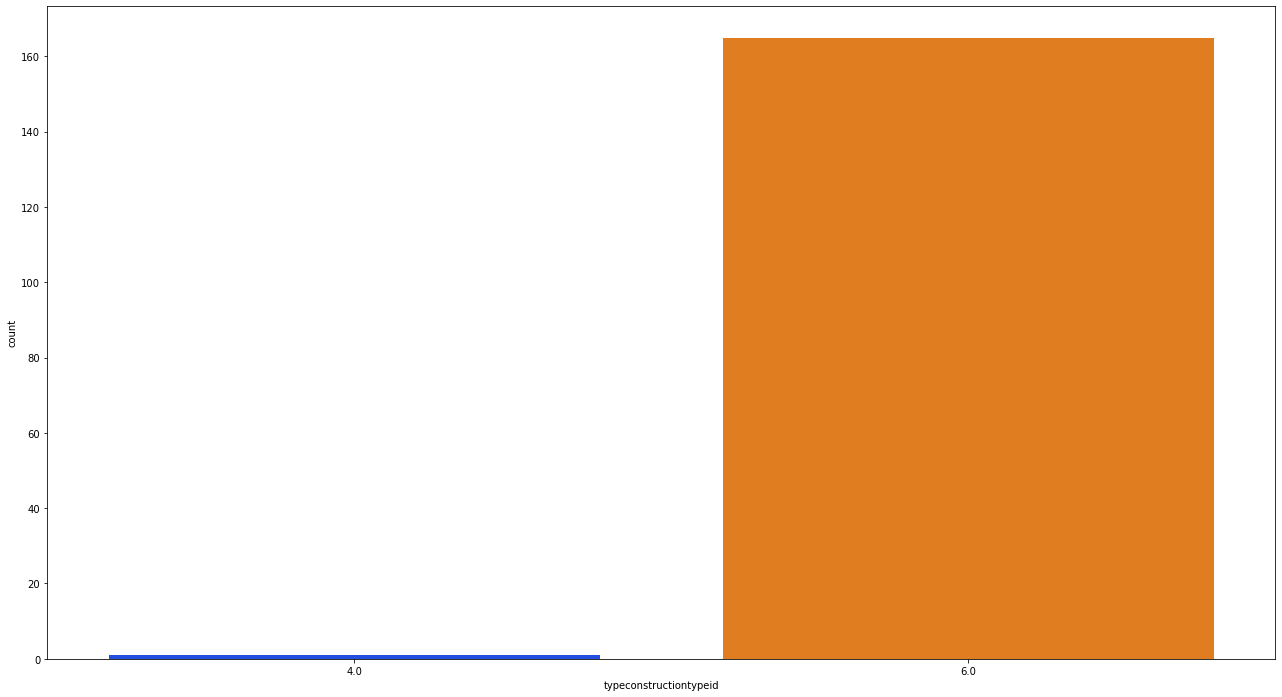

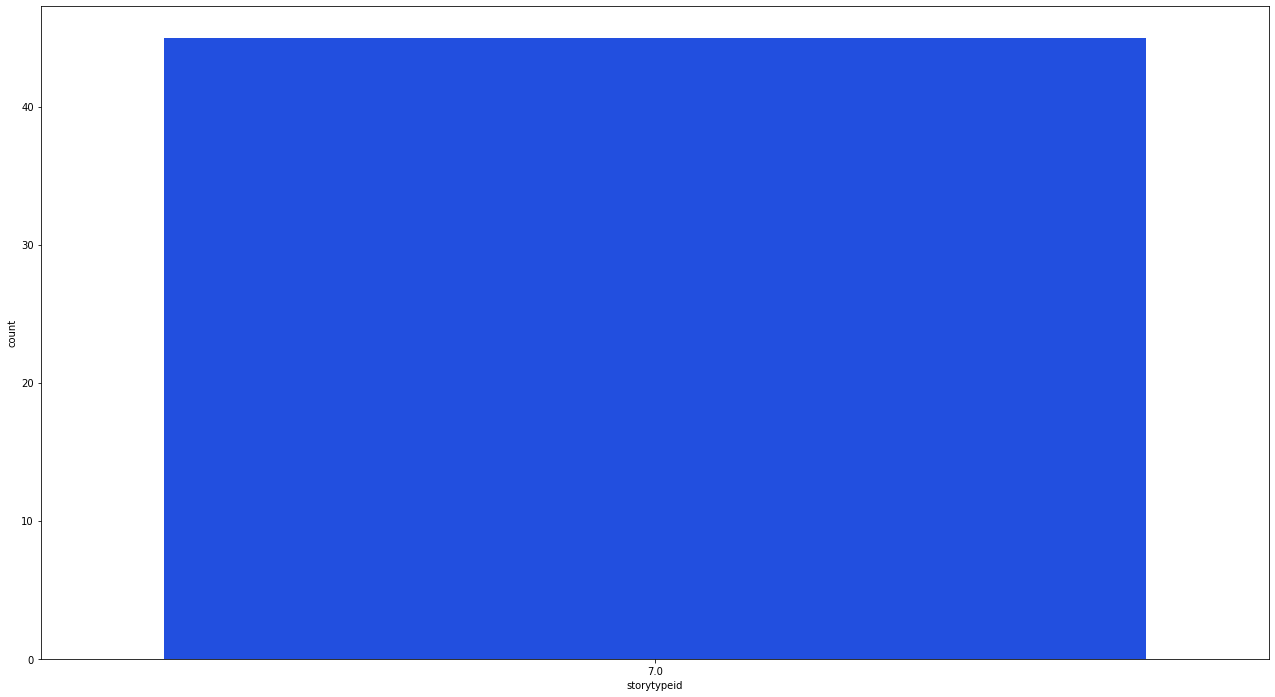

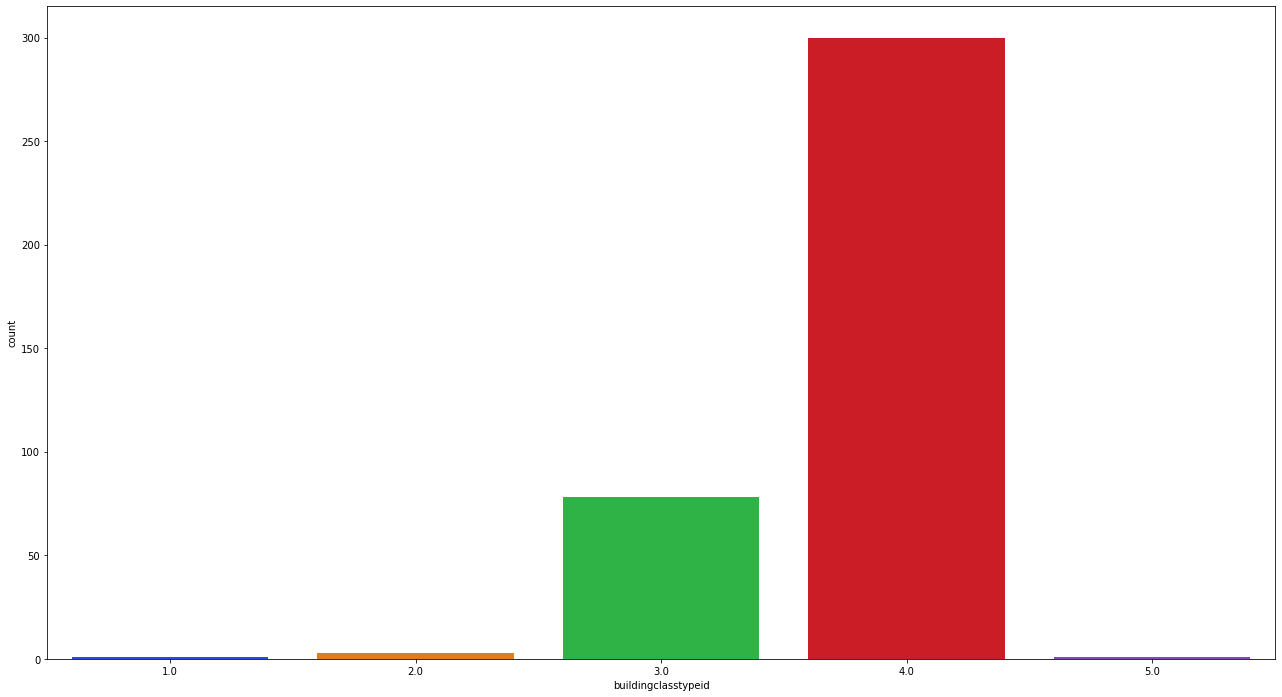

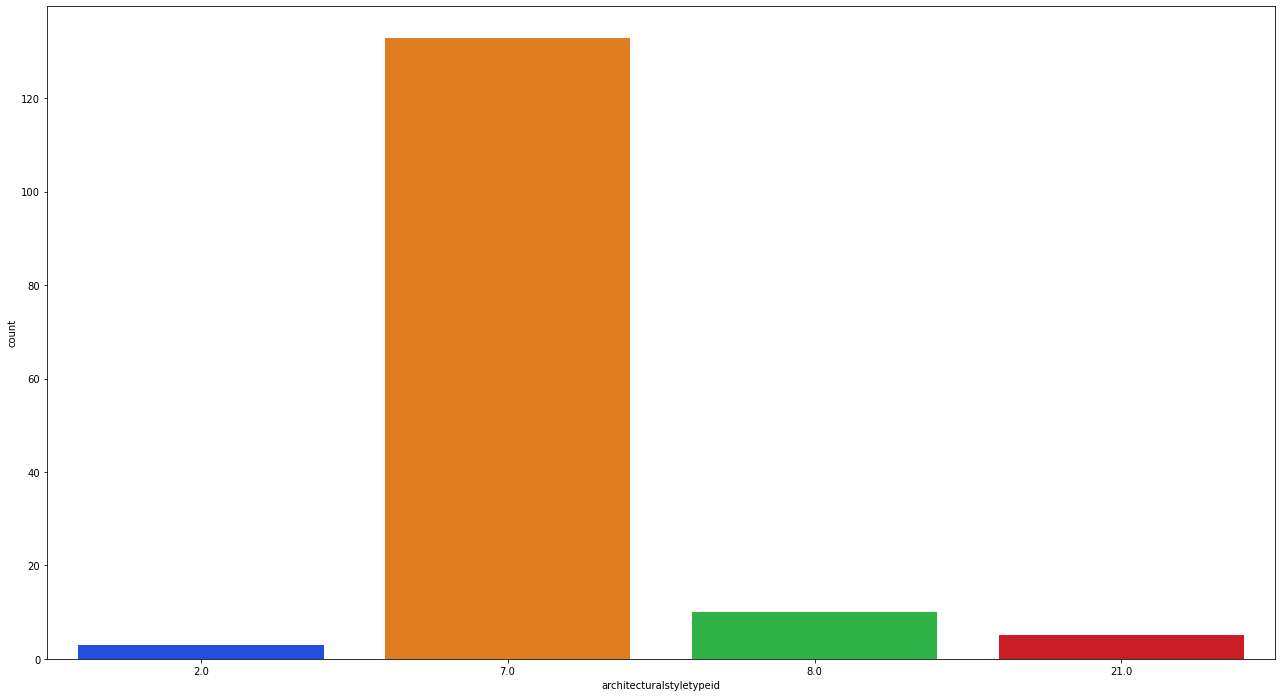

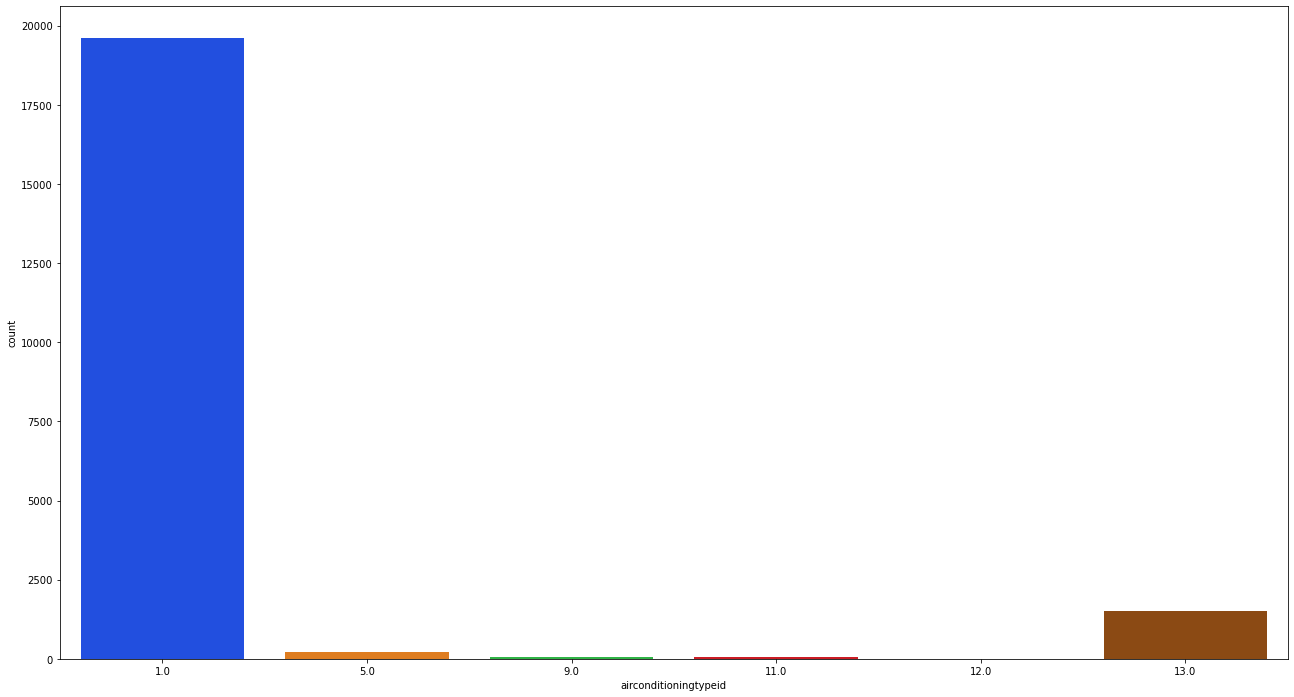

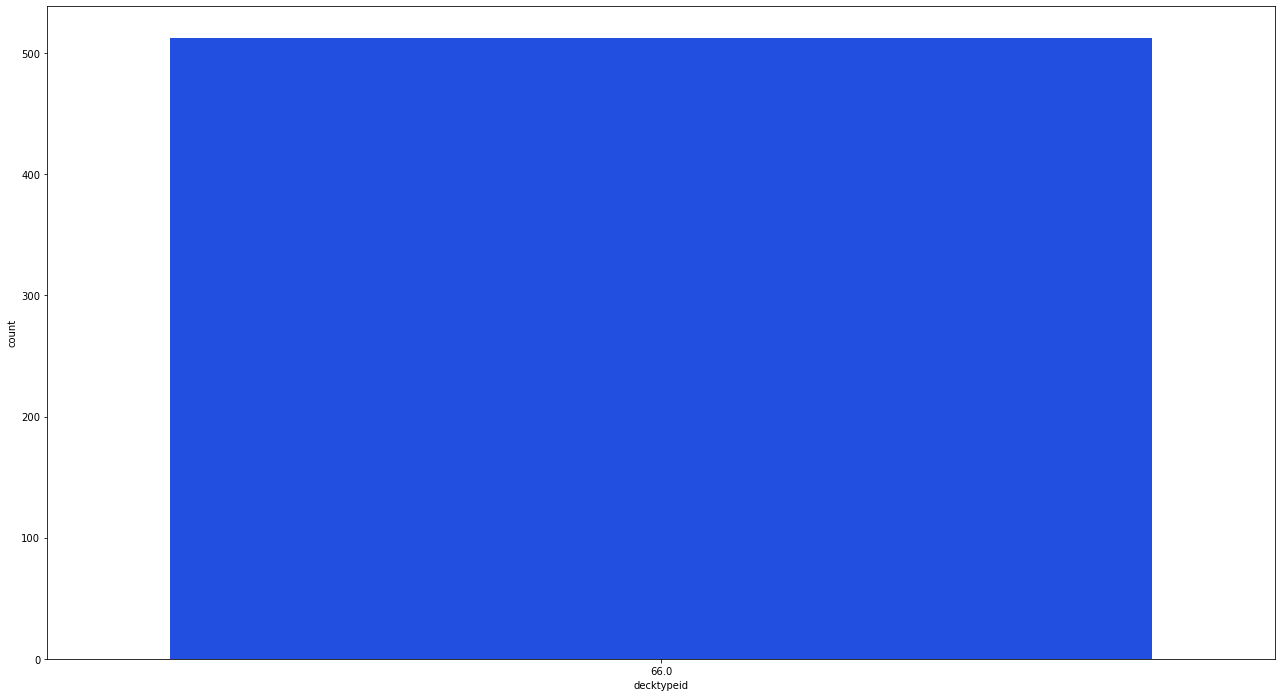

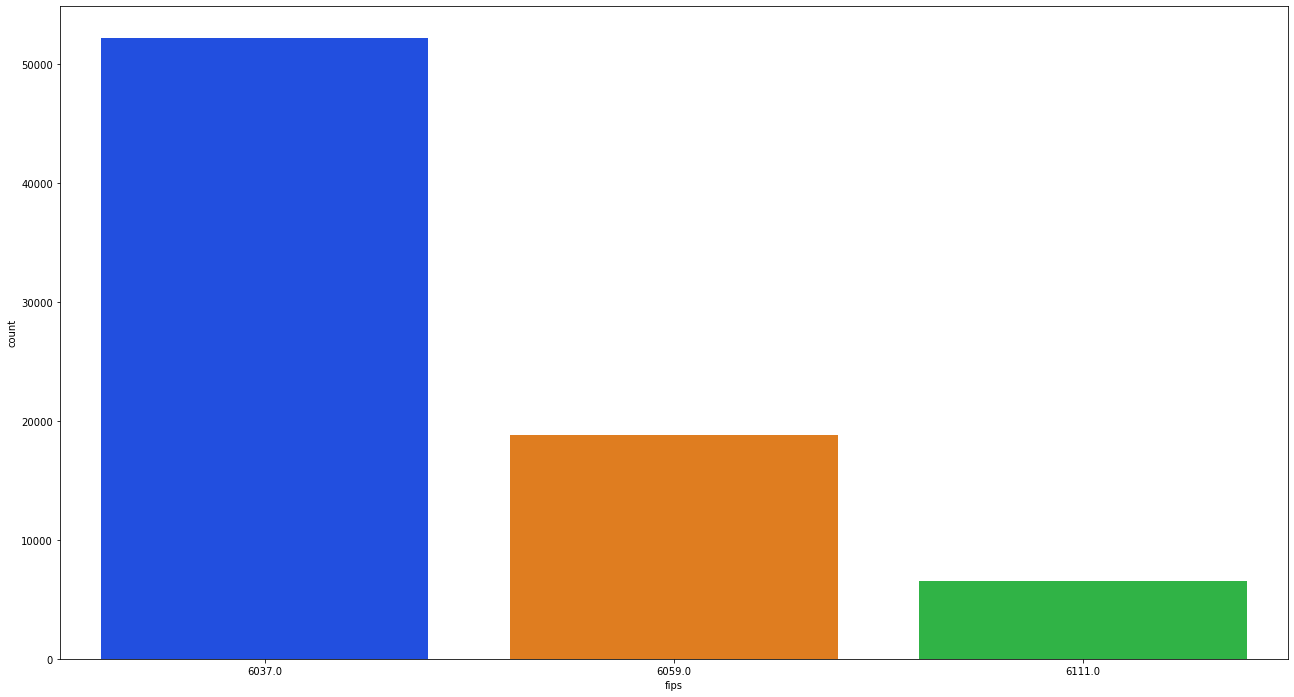

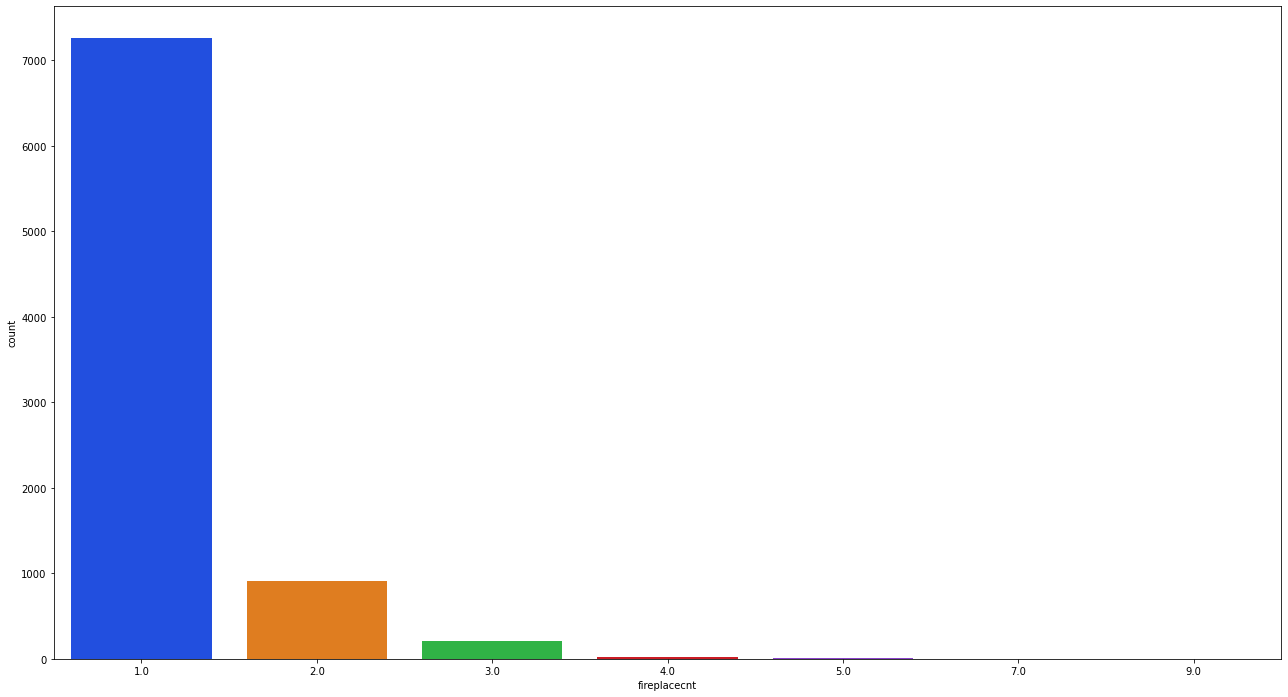

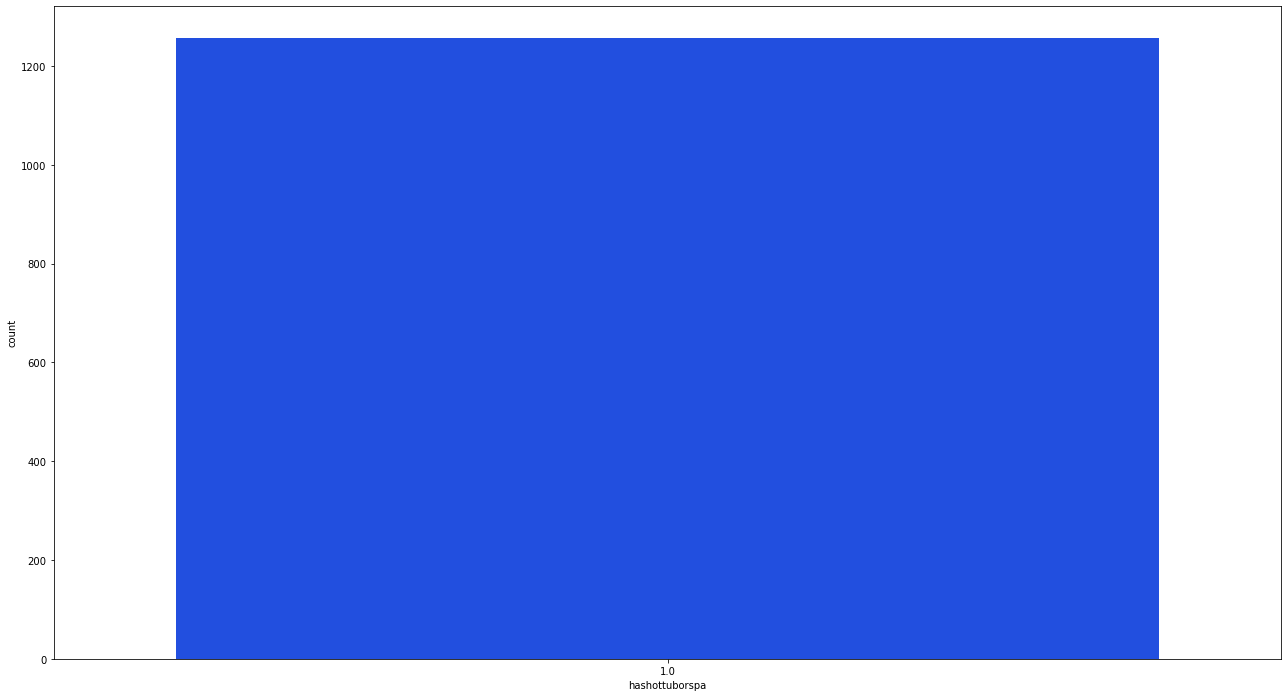

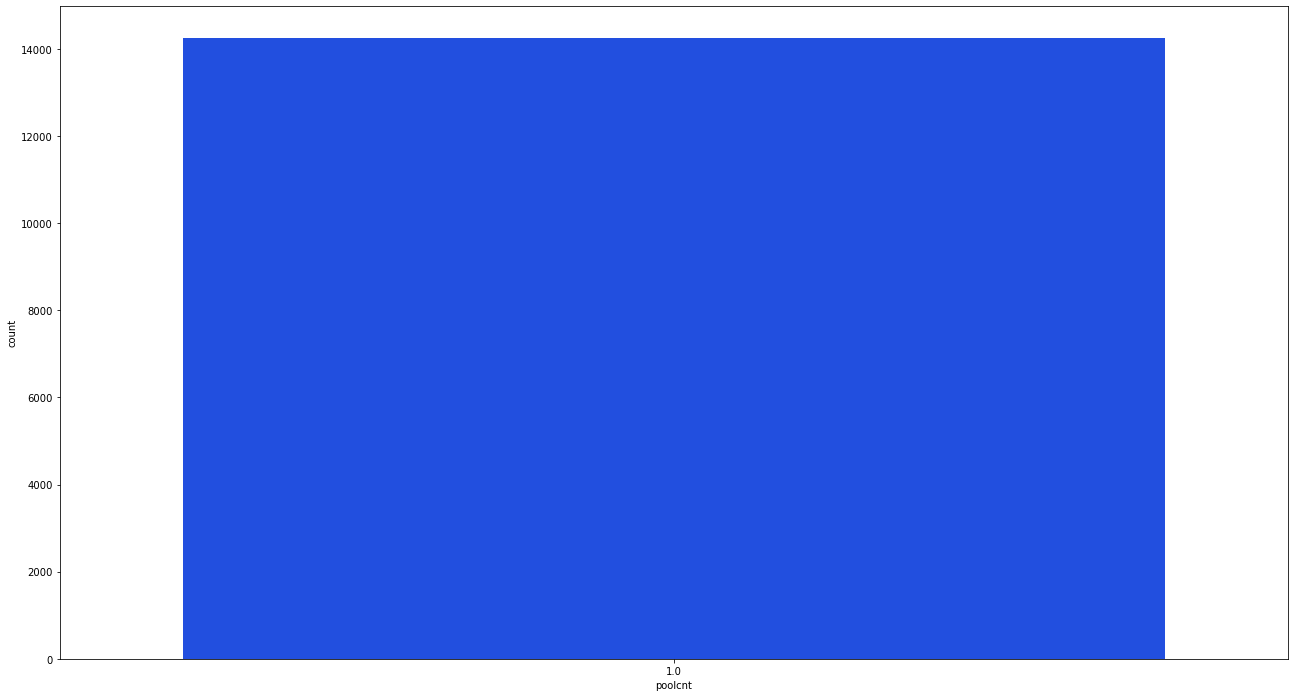

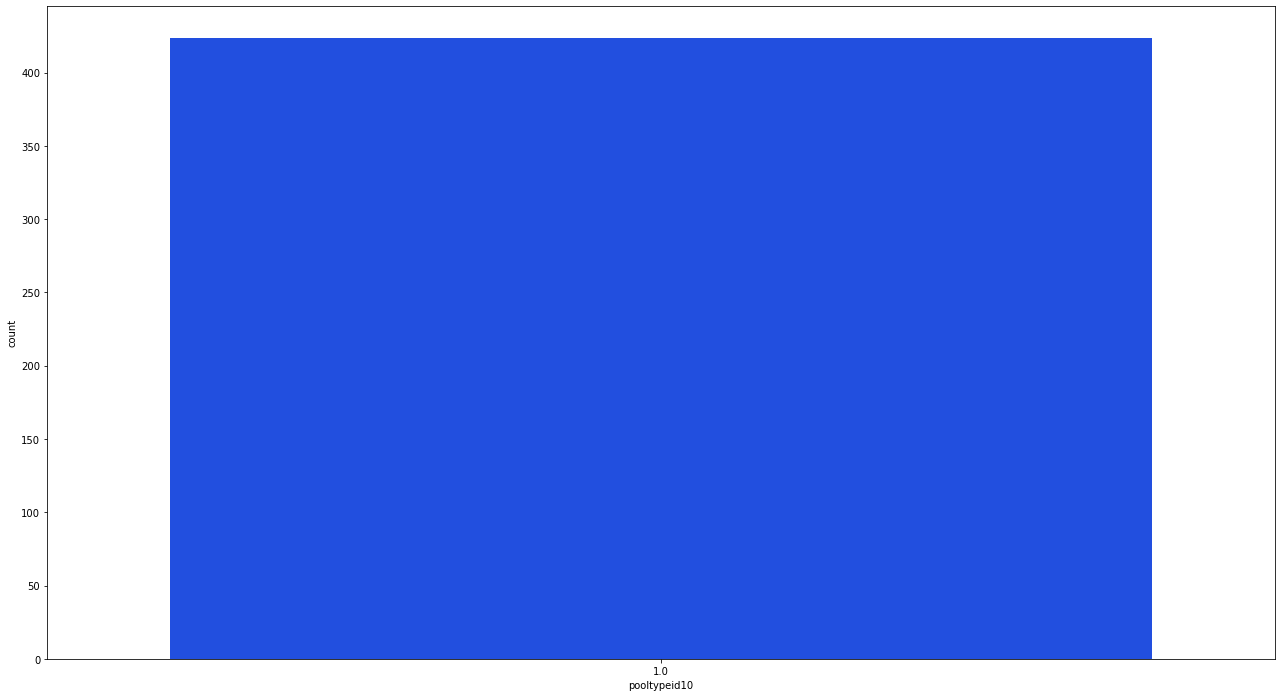

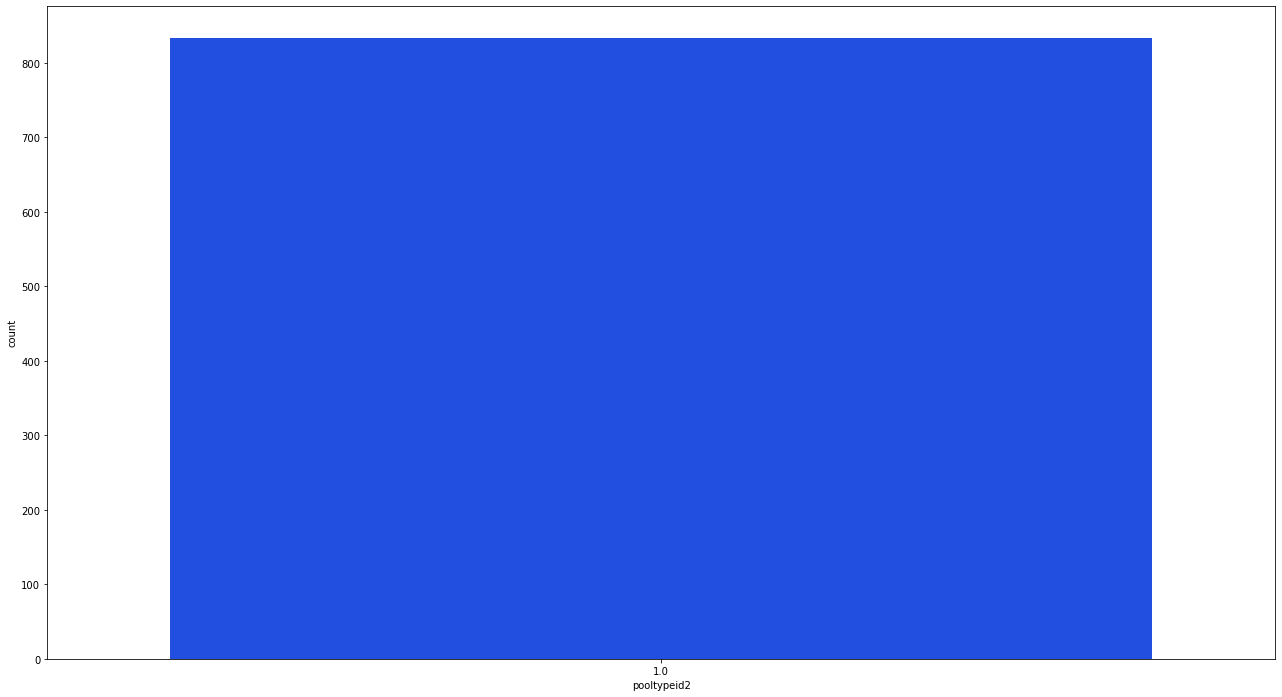

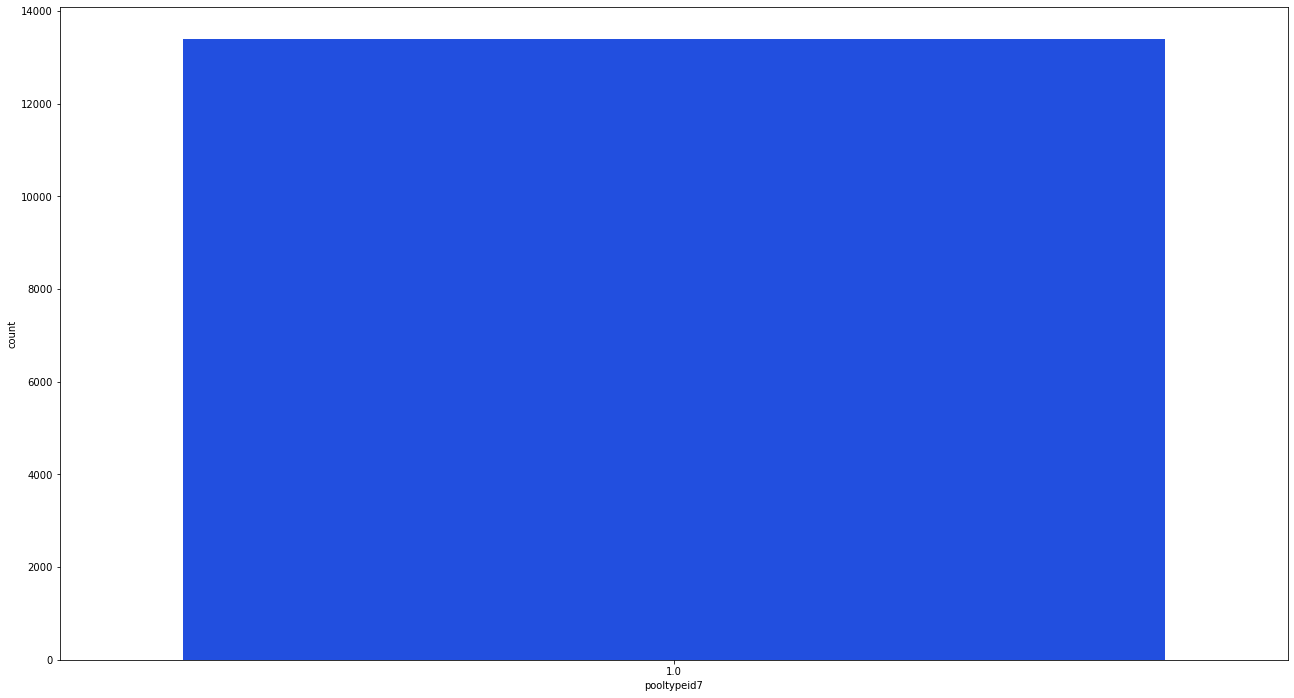

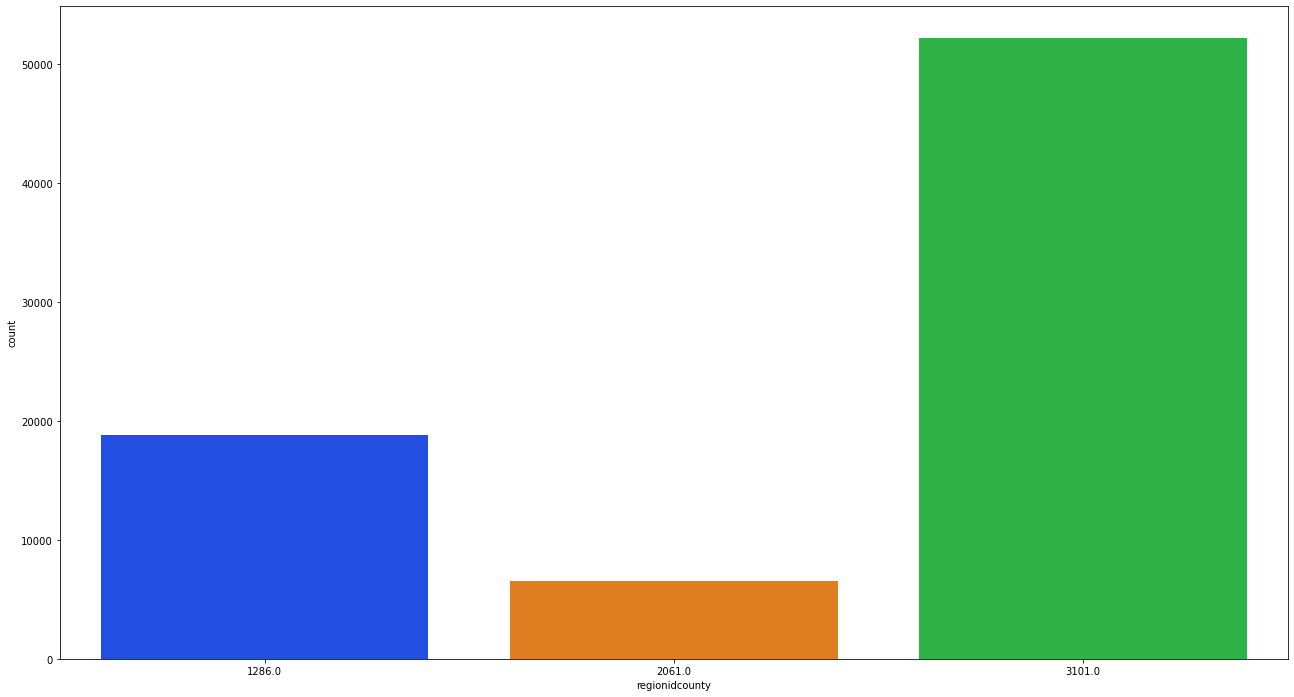

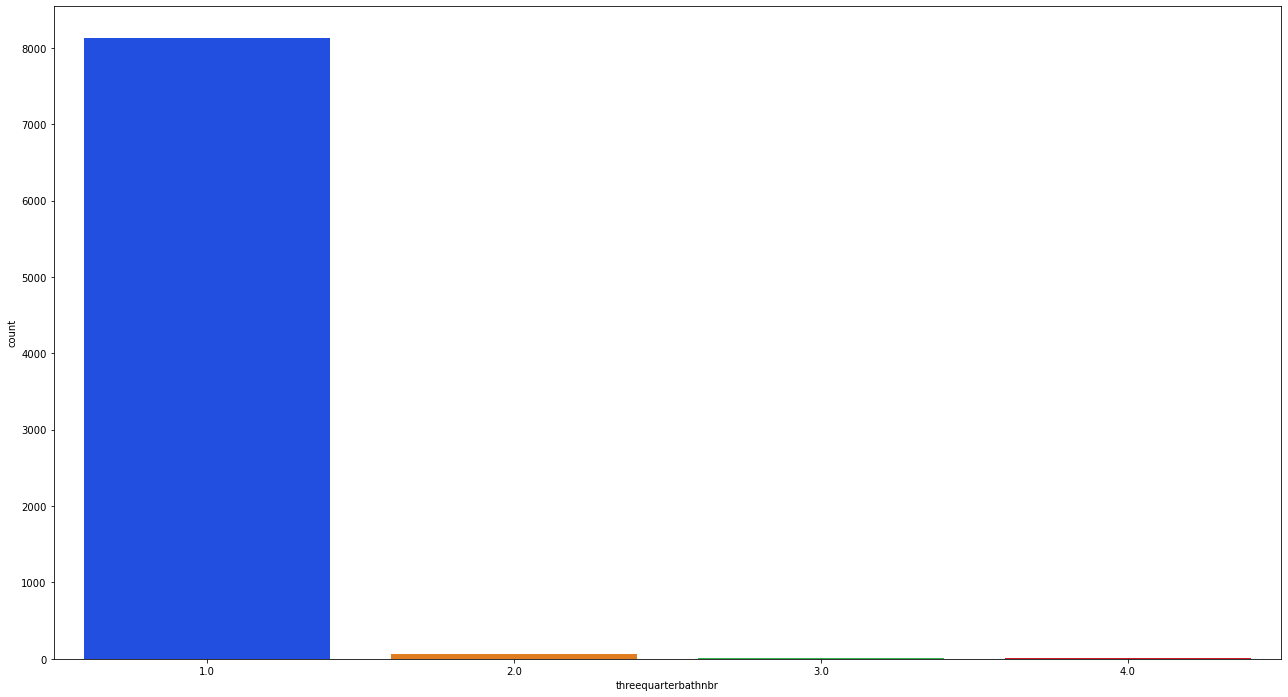

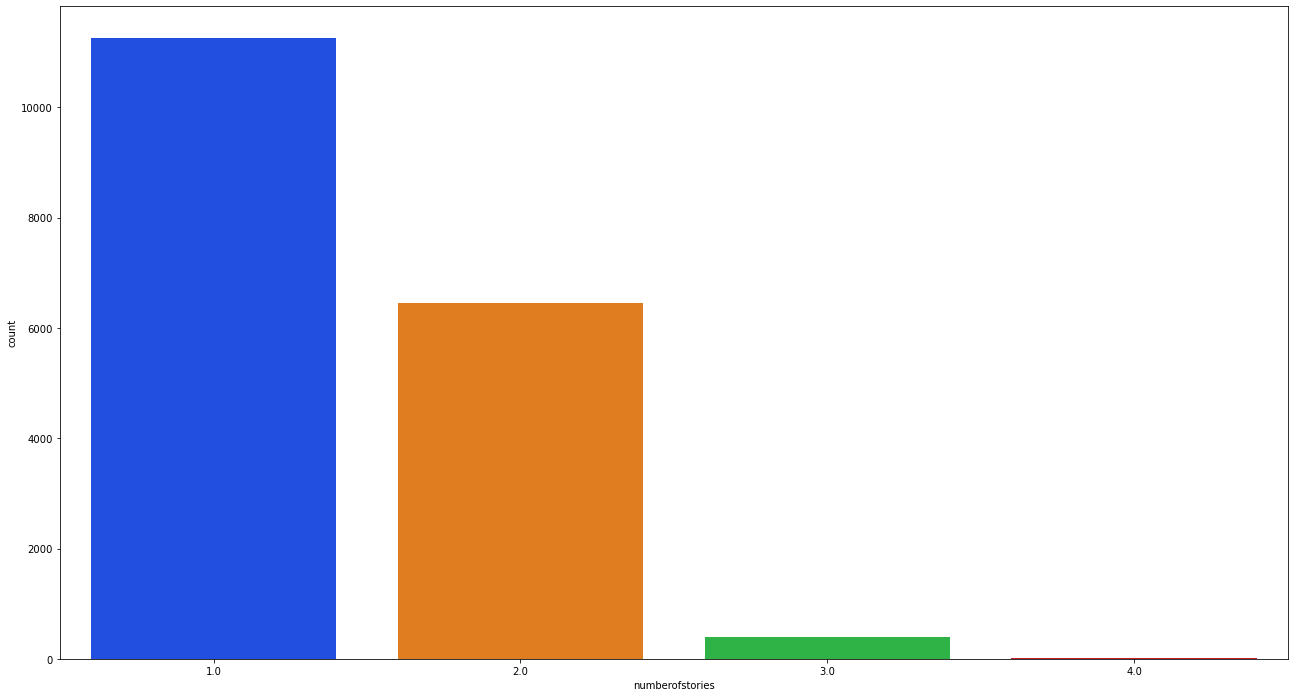

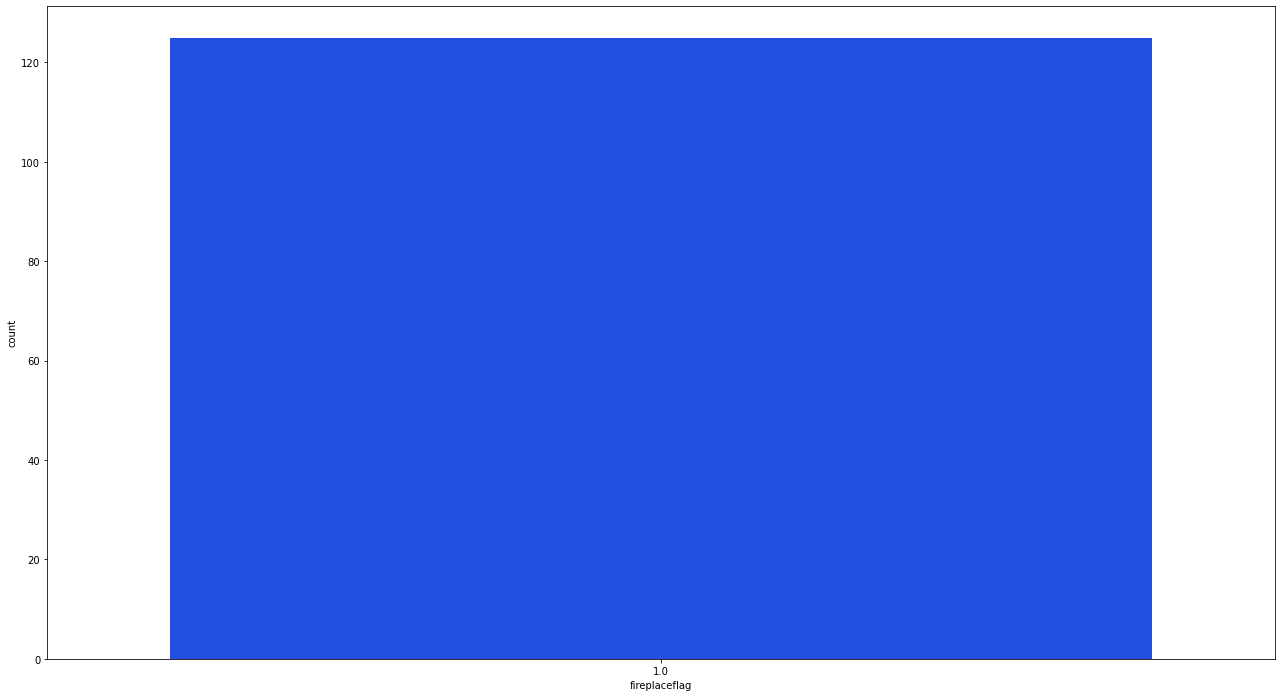

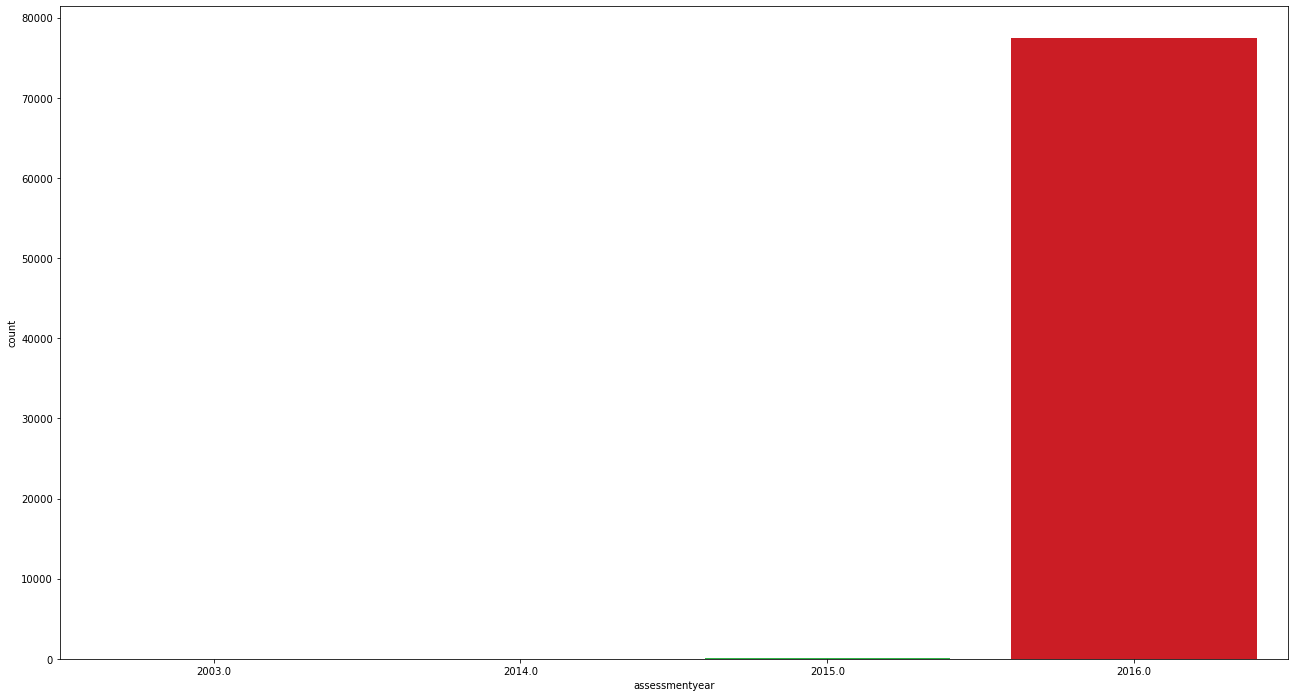

In [107]:
graph_features(df)

<AxesSubplot:xlabel='typeconstructiondesc', ylabel='count'>

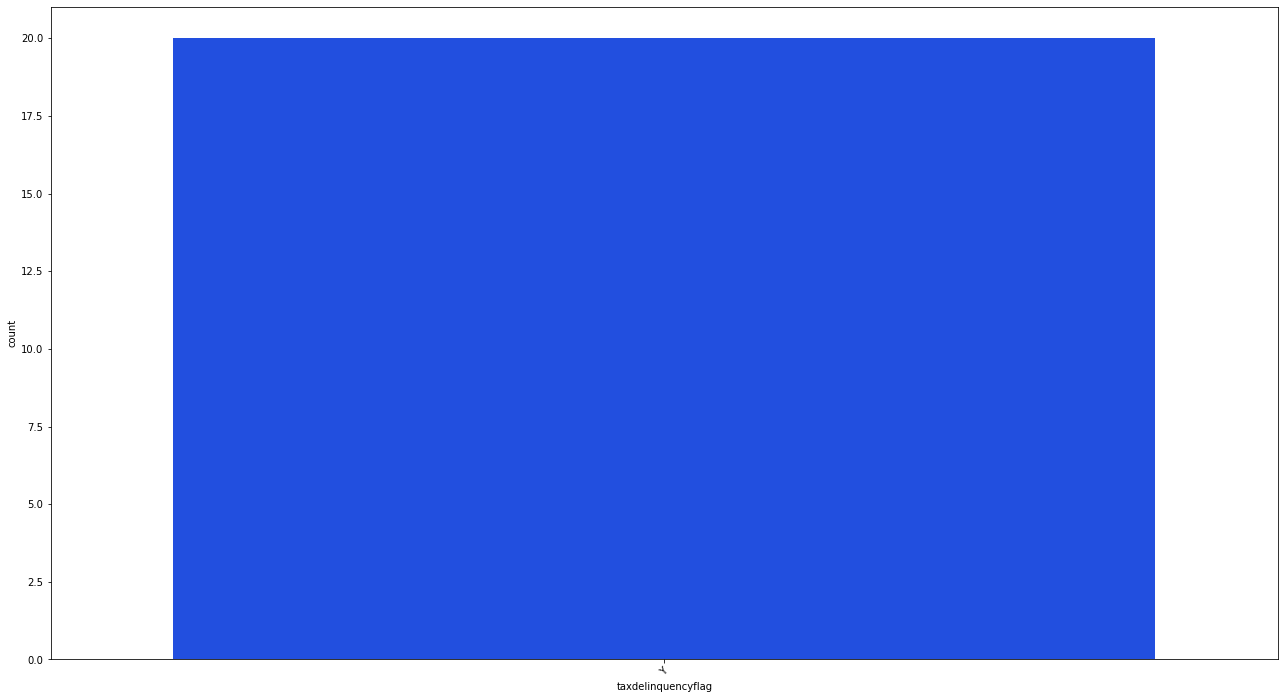

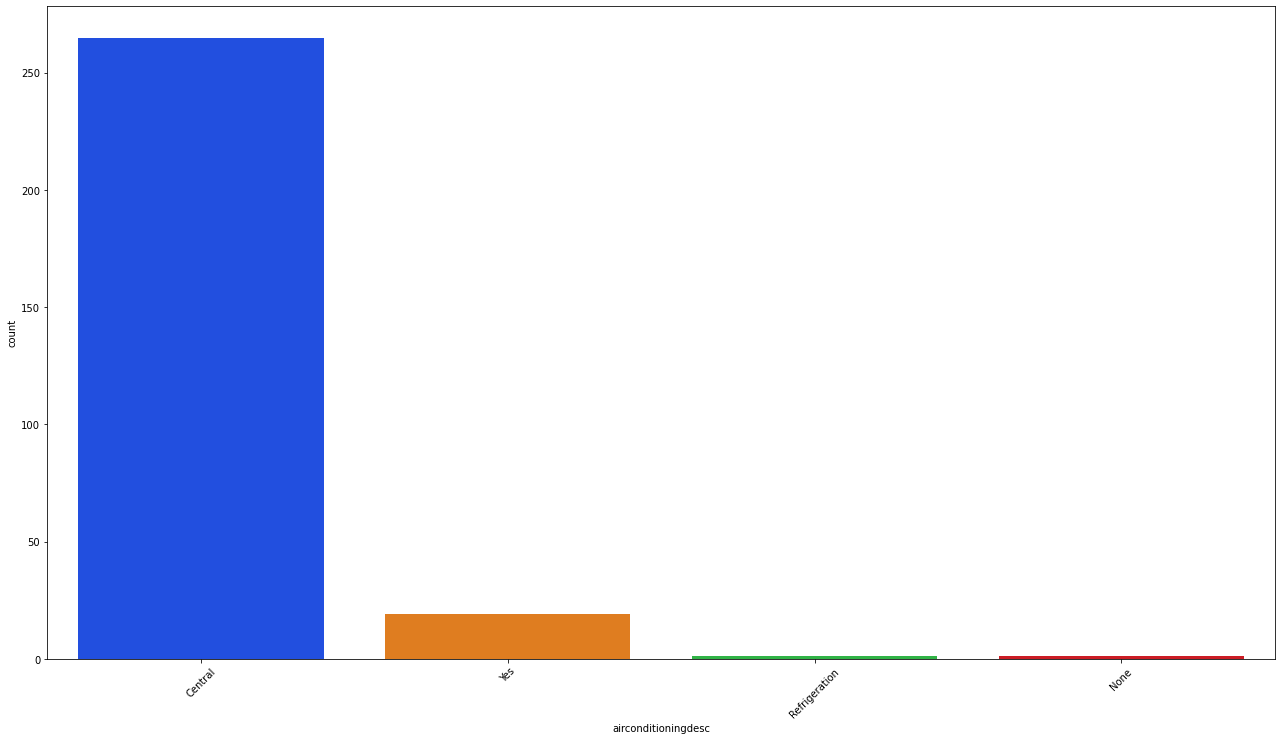

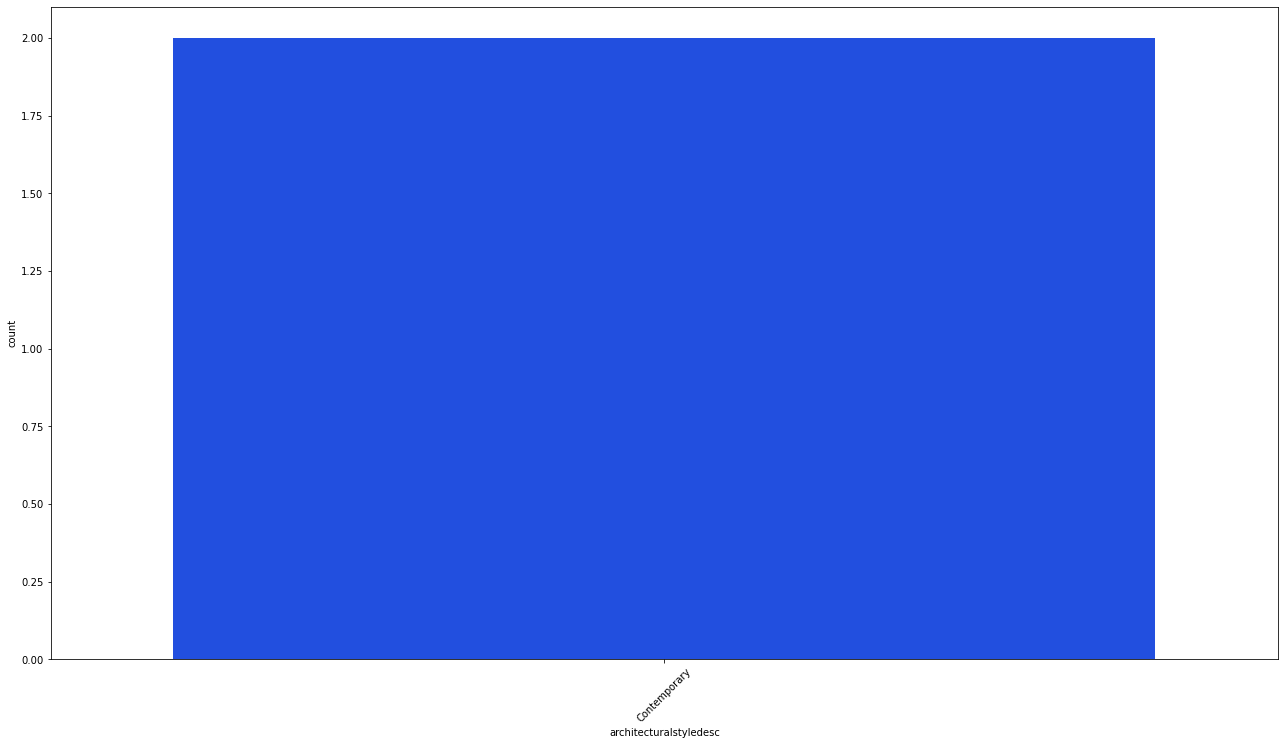

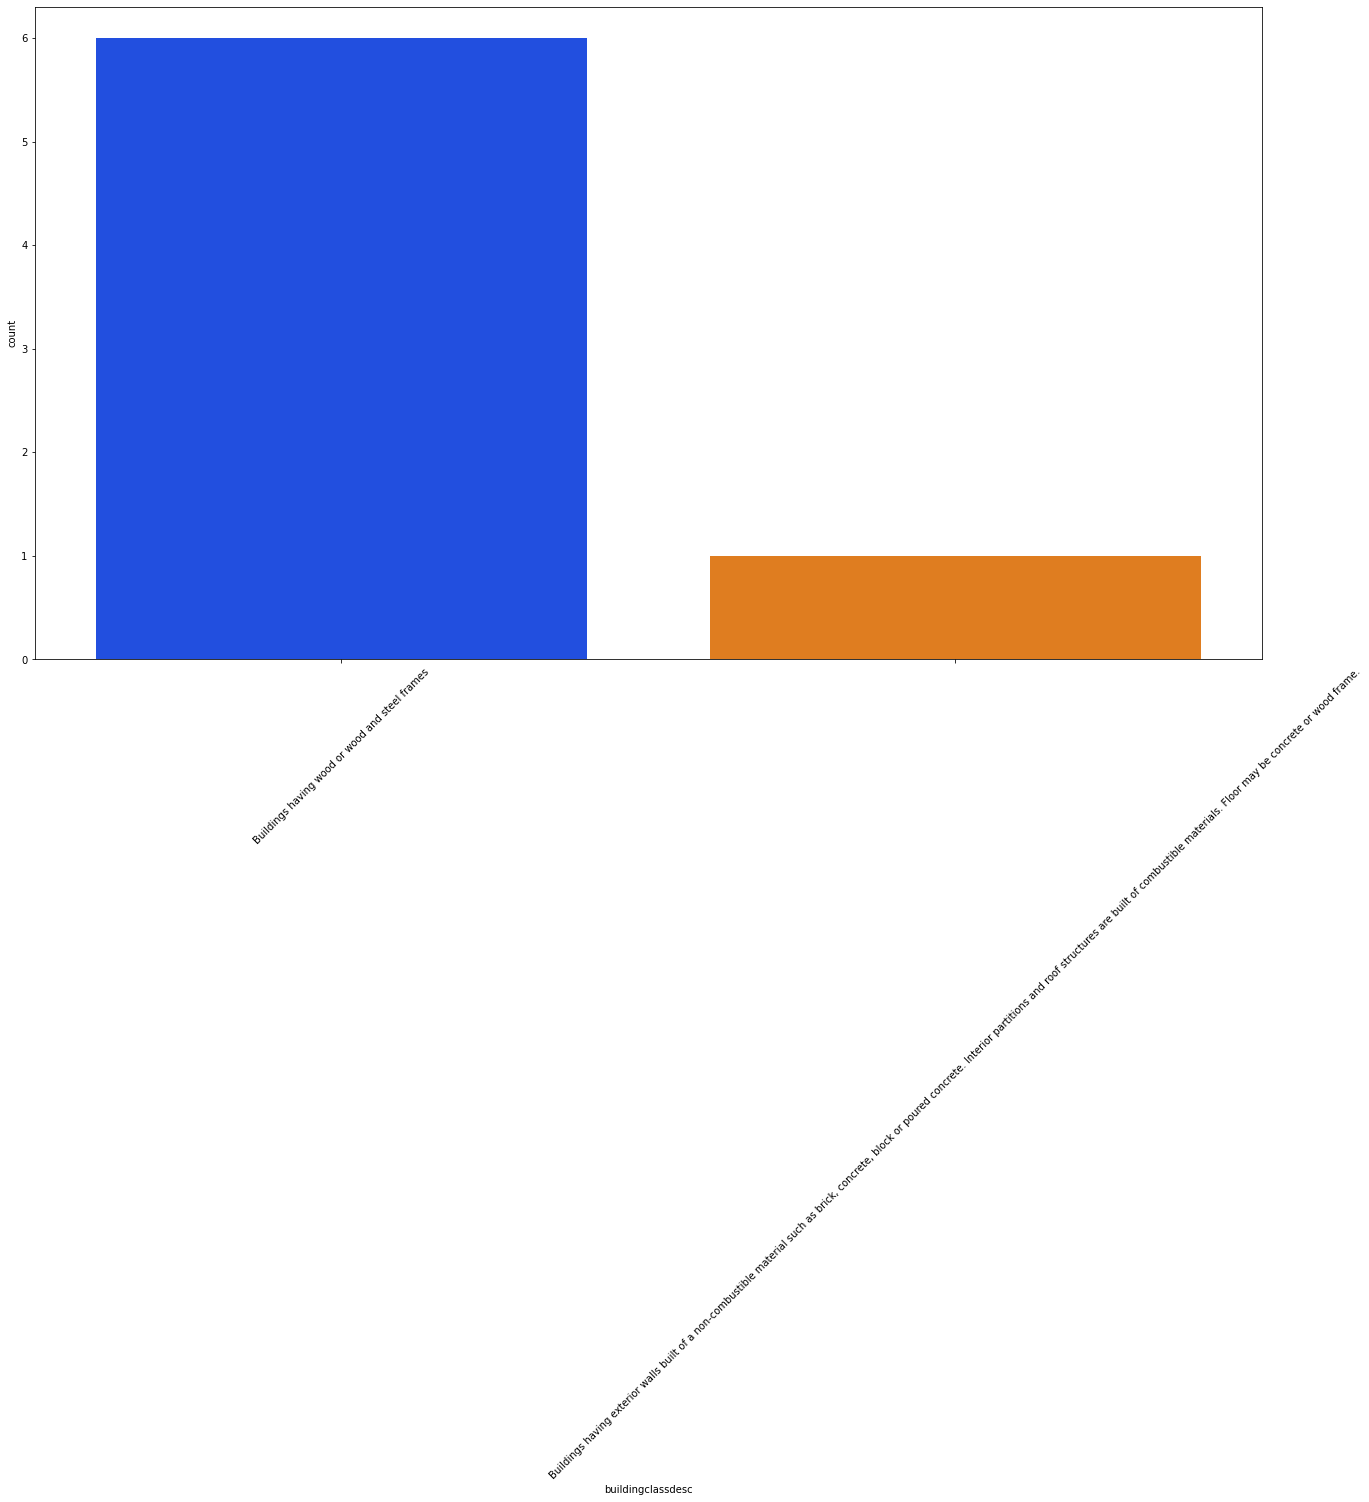

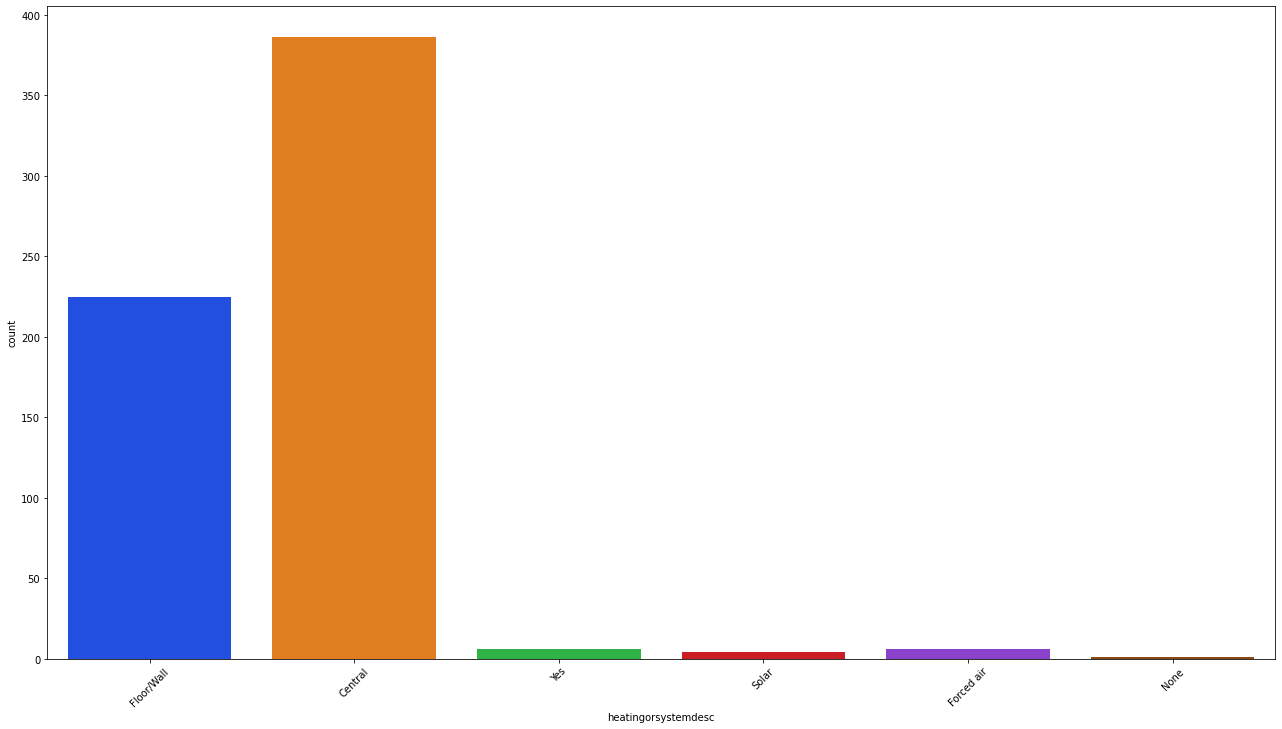

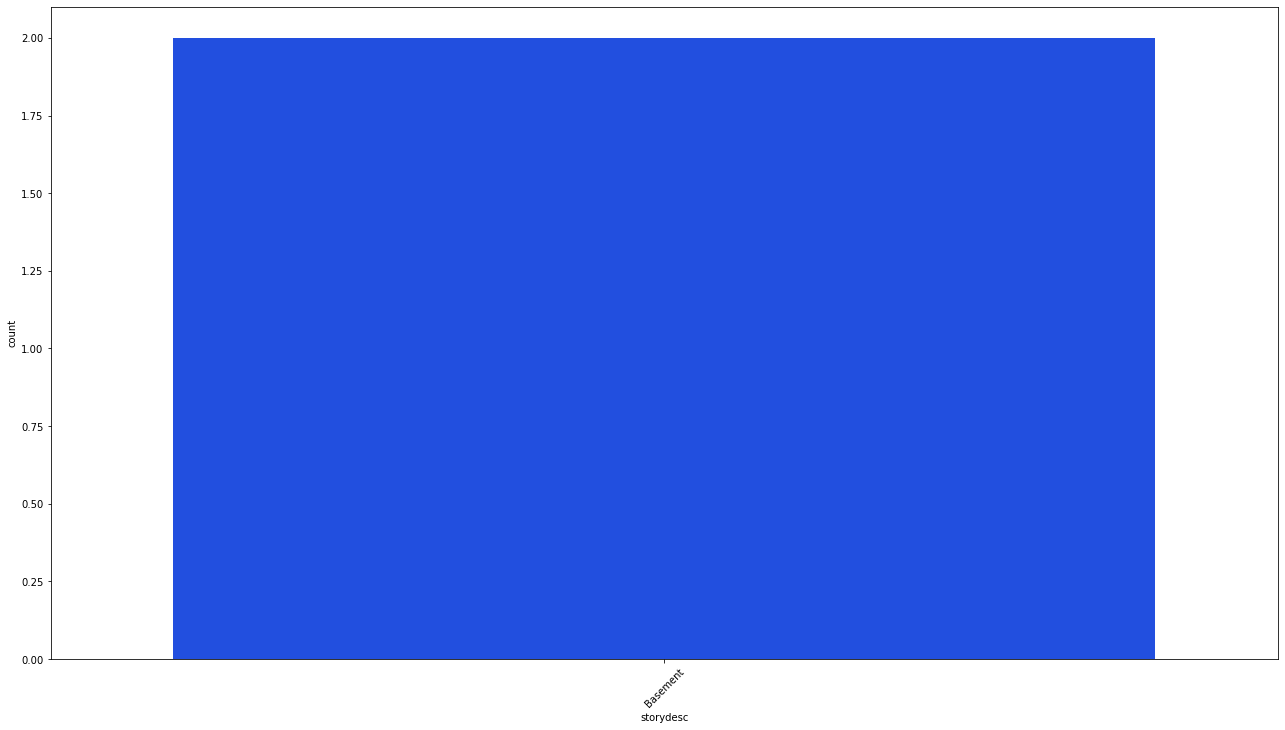

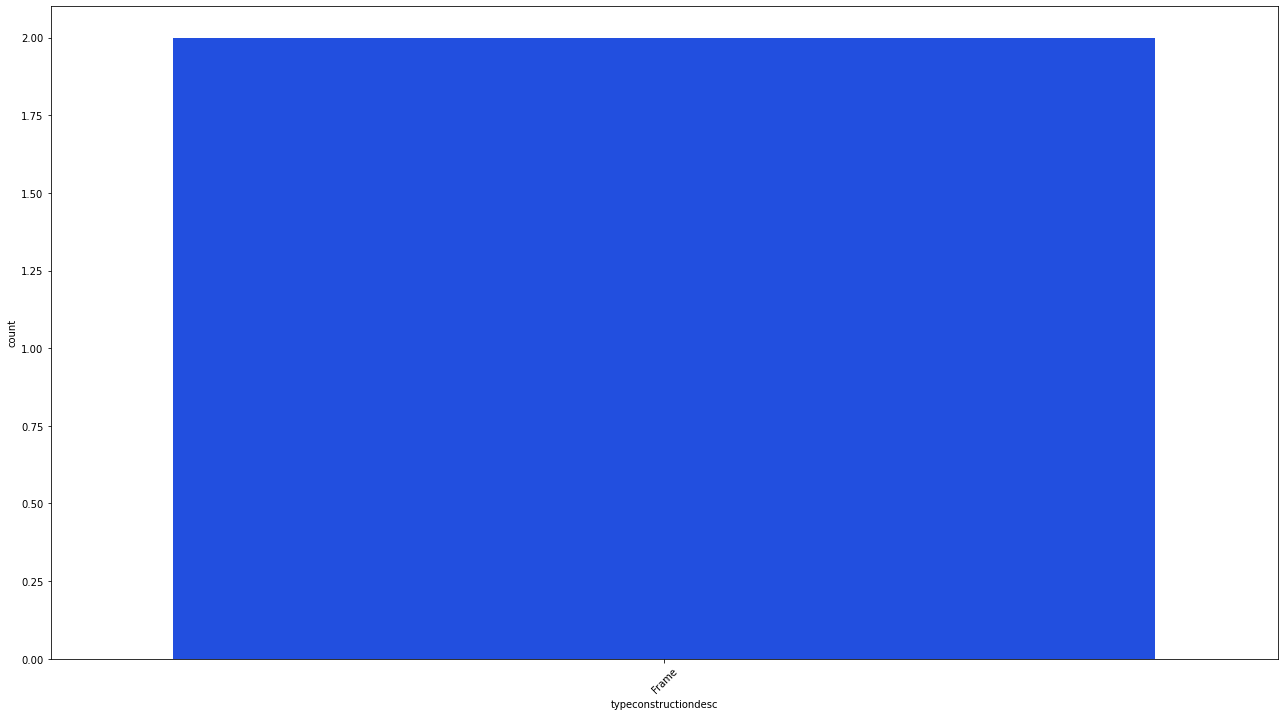

In [112]:
graph_objects_counts(df.sample(1000))

<AxesSubplot:xlabel='propertylandusedesc', ylabel='count'>

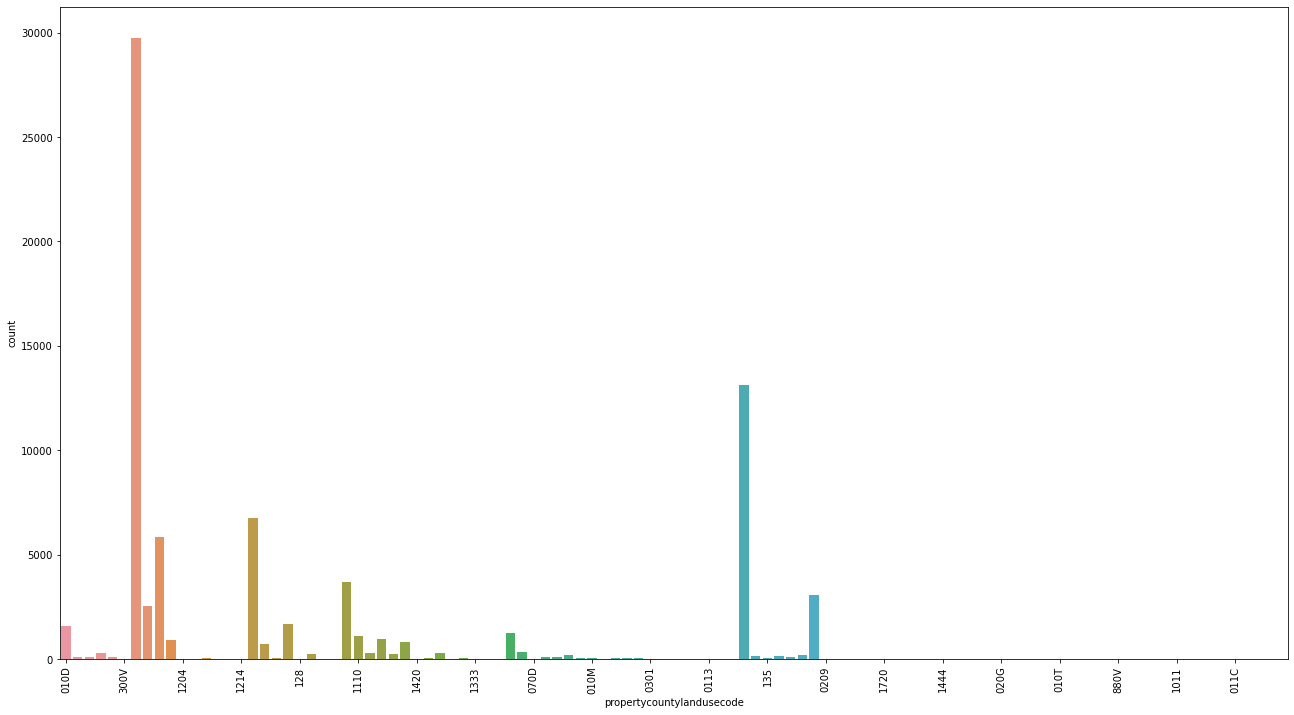

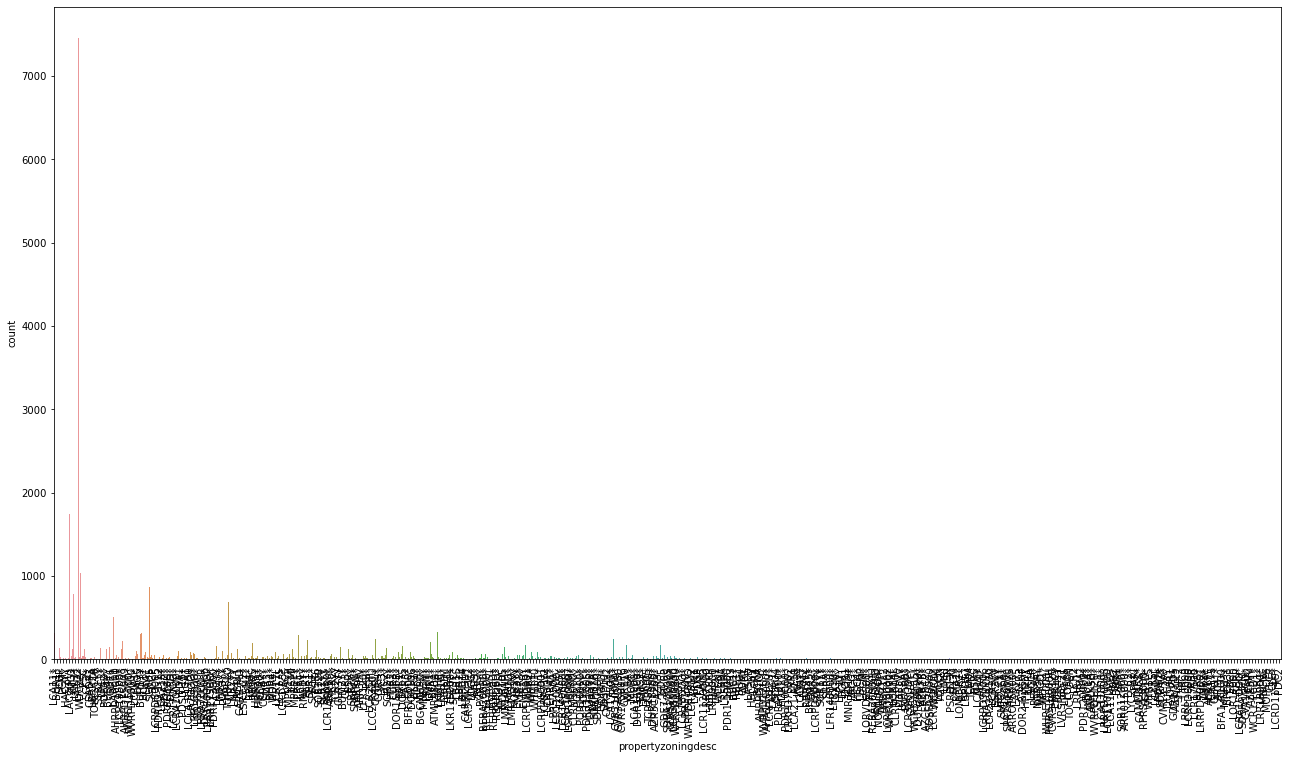

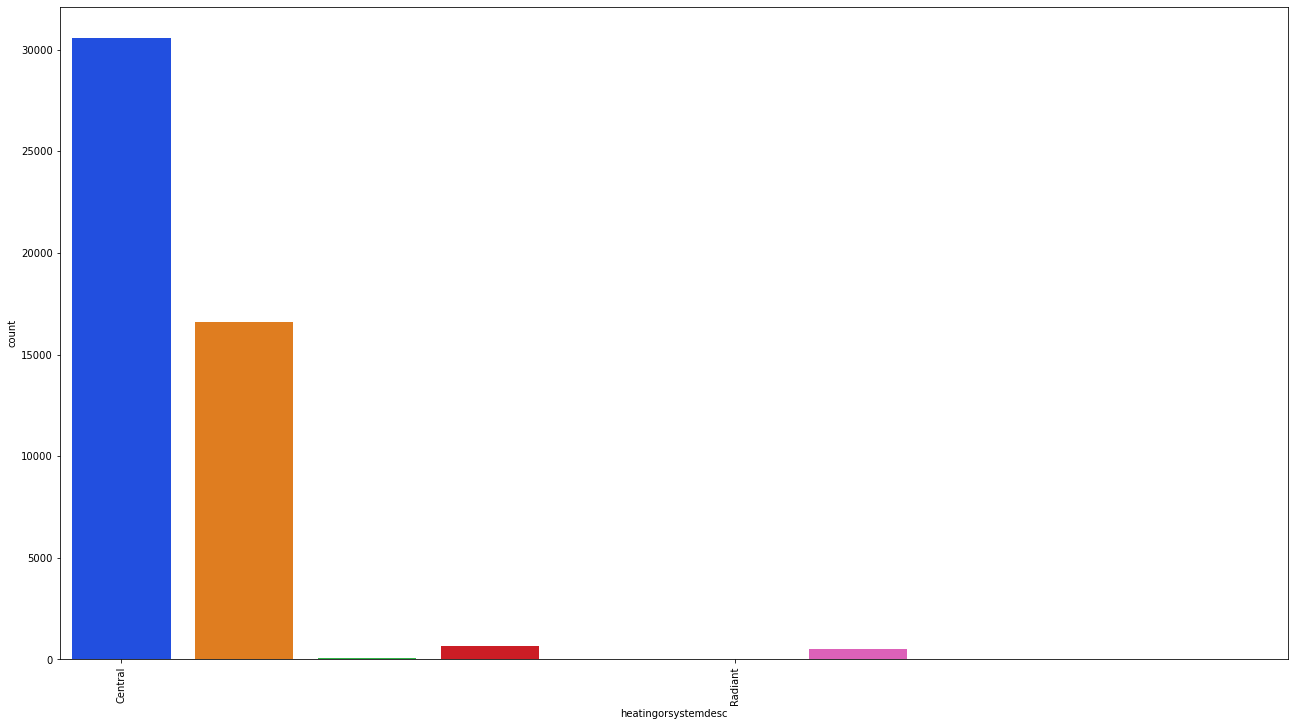

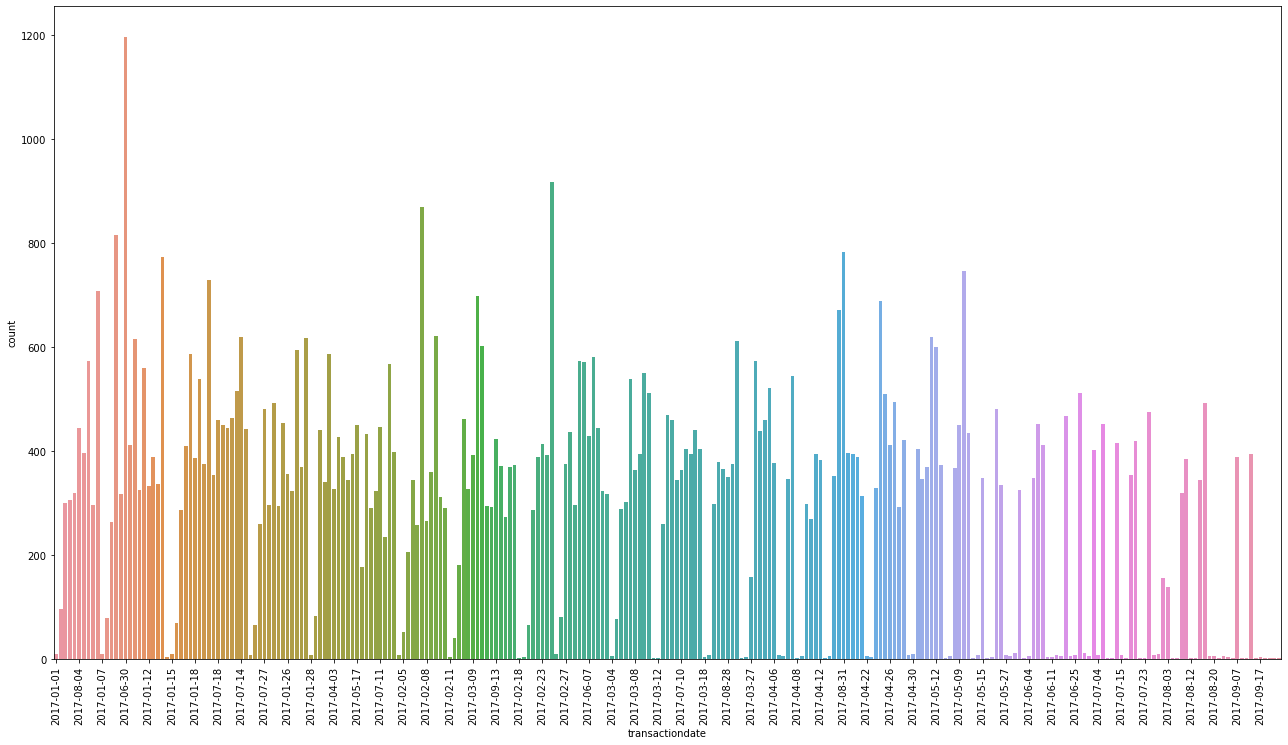

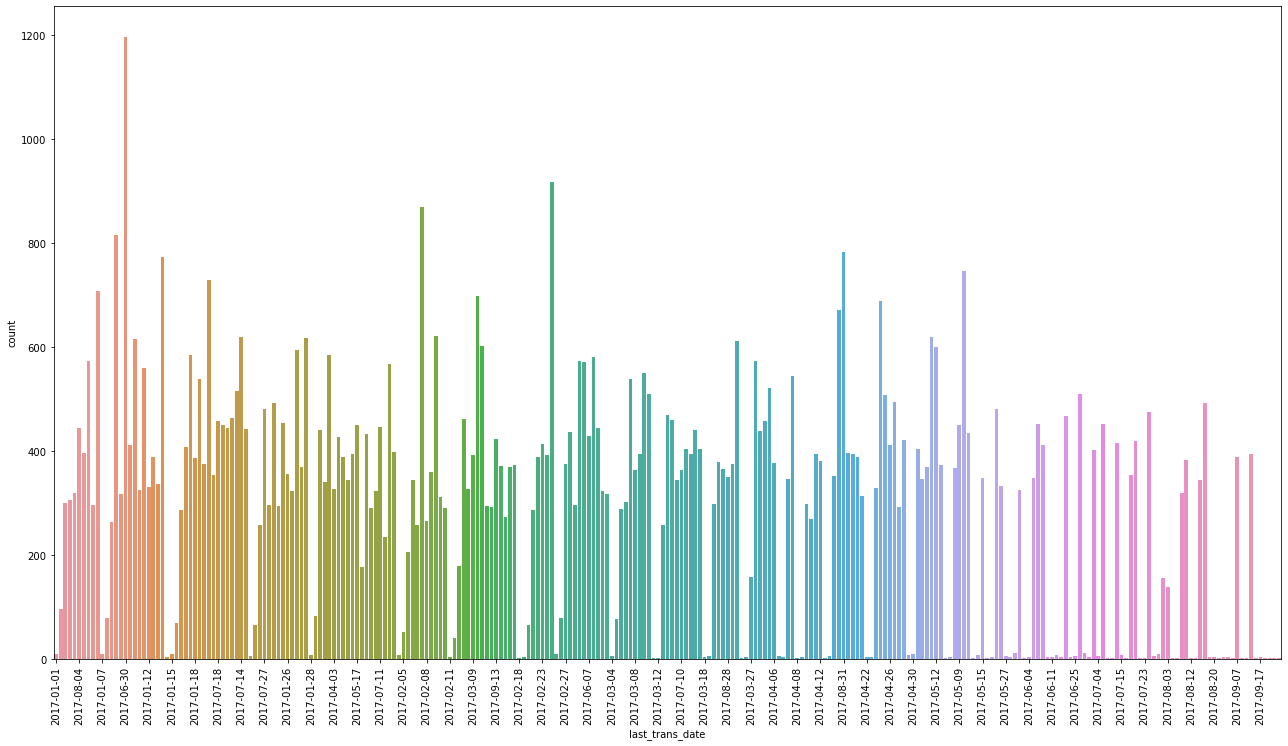

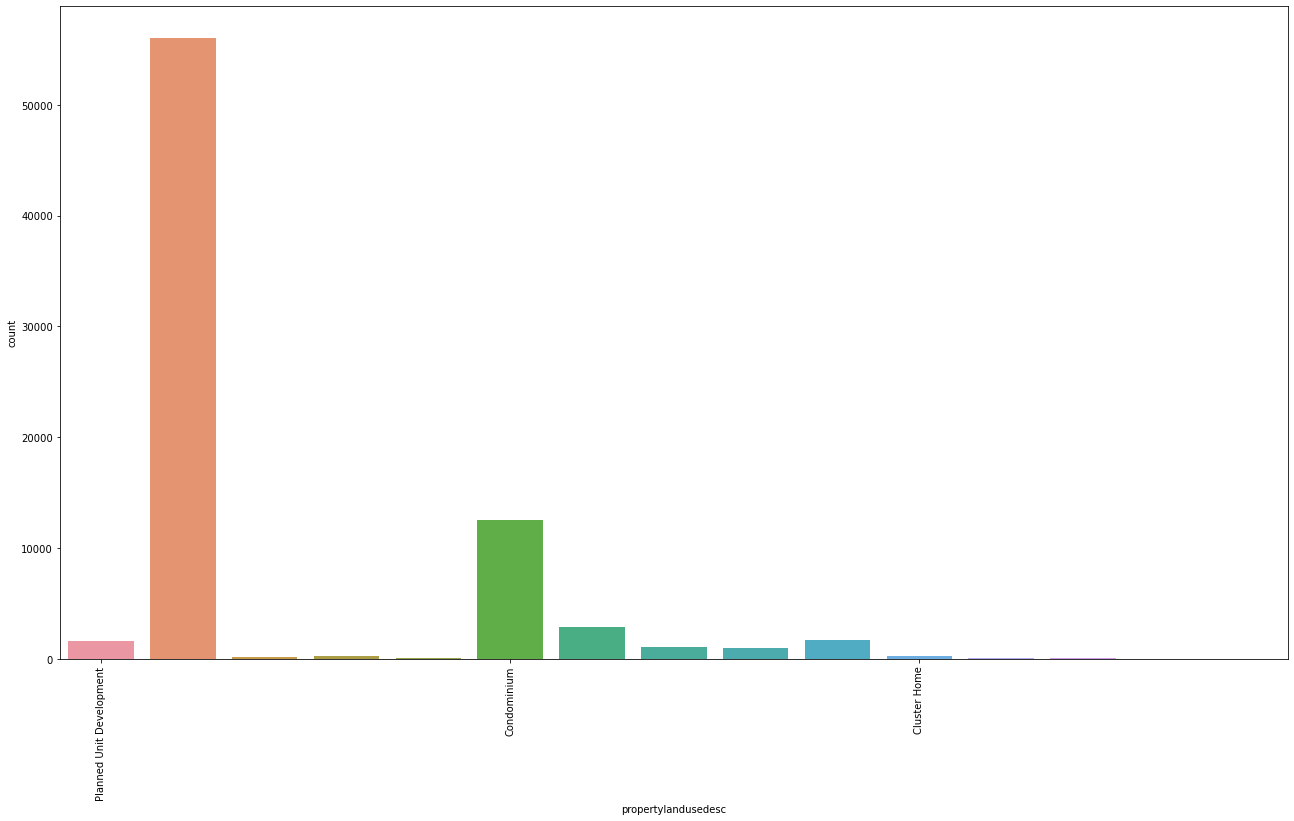

In [119]:
graph_objects_distributions(df)

In [122]:
for col in df.columns:
    if df[col].dtype == object and len(df[col].unique()) >= 10:
        print(col)

propertycountylandusecode
propertyzoningdesc
heatingorsystemdesc
transactiondate
last_trans_date
propertylandusedesc


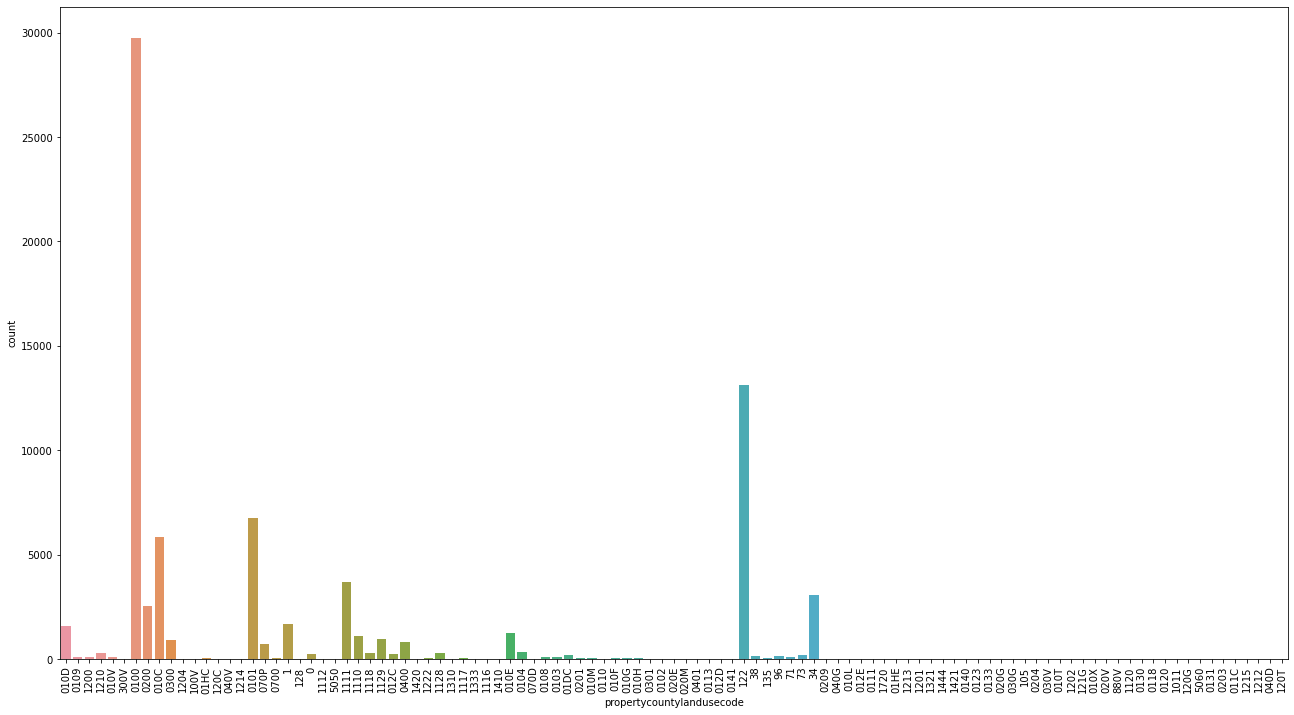

In [128]:
plt.figure(figsize=(22, 12))
landusecode = sns.countplot(x = df.propertycountylandusecode, data = df)
x_ticks = plt.xticks(rotation = 90)

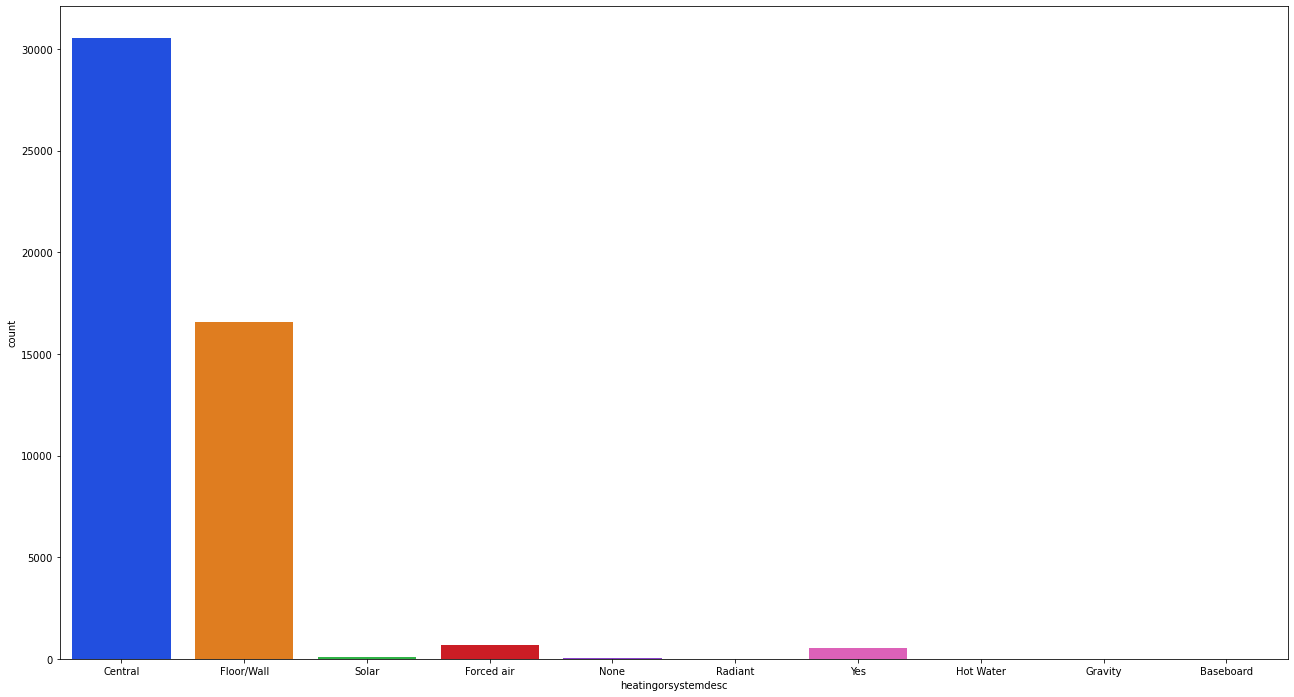

In [136]:
plt.figure(figsize=(22, 12))
heating = sns.countplot(x = df.heatingorsystemdesc, data = df.sample(1000))


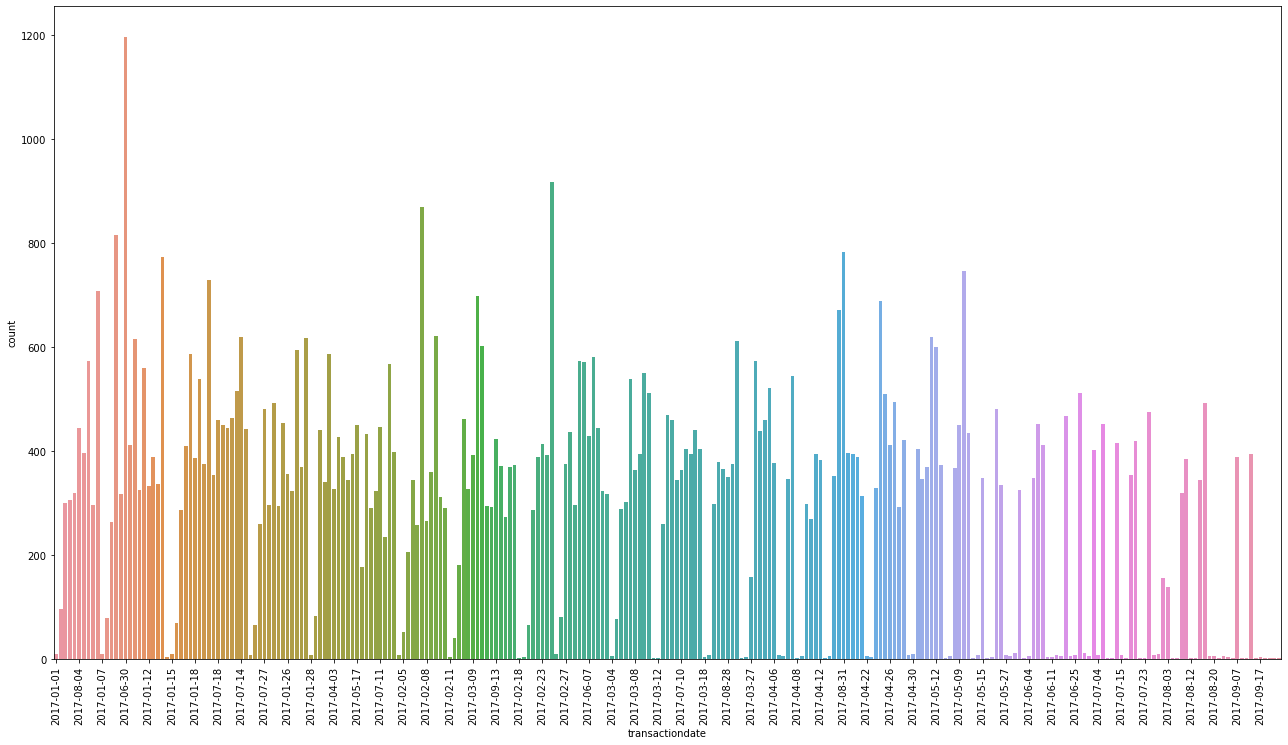

In [141]:
plt.figure(figsize=(22, 12))
transaction = sns.countplot(x = df.transactiondate, data = df.sample(1000))
x_ticks = plt.xticks(rotation = 90)
labels = transaction.set_xticks(transaction.get_xticks()[::5])

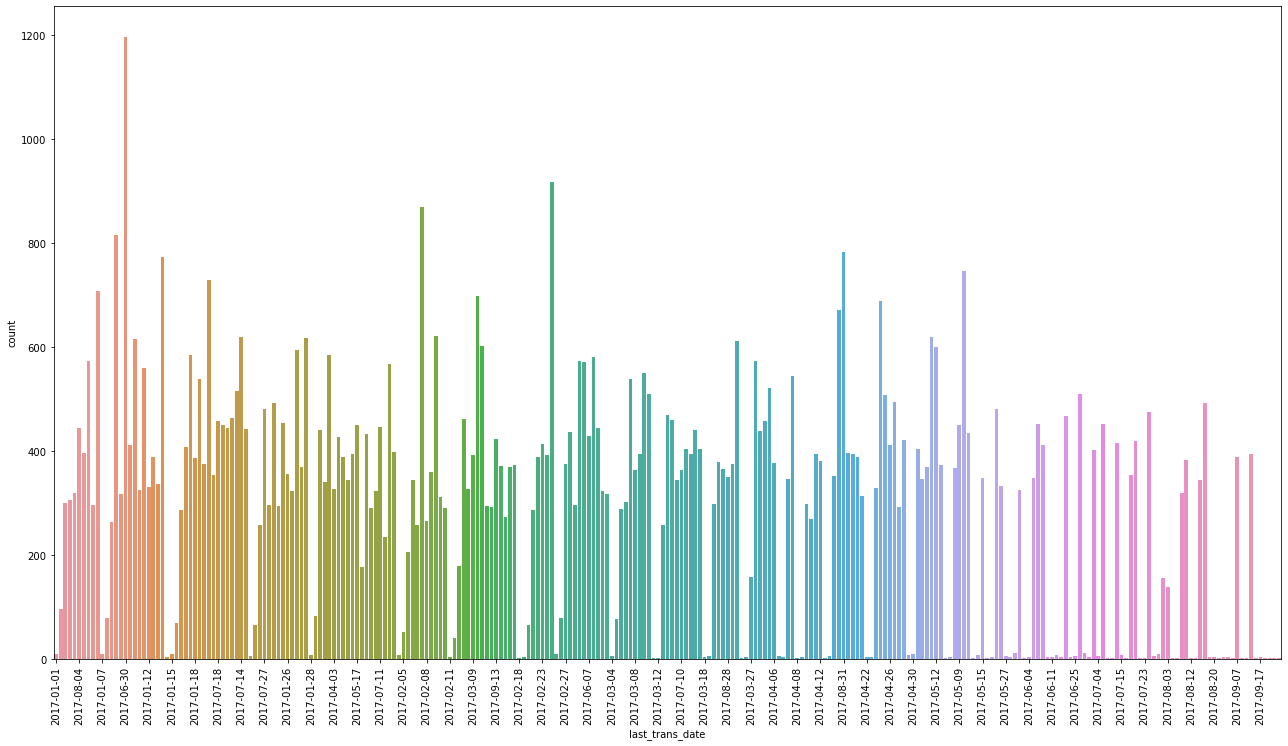

In [142]:
plt.figure(figsize=(22, 12))
last_transaction = sns.countplot(x = df.last_trans_date, data = df.sample(1000))
x_ticks = plt.xticks(rotation = 90)
labels = last_transaction.set_xticks(last_transaction.get_xticks()[::5])

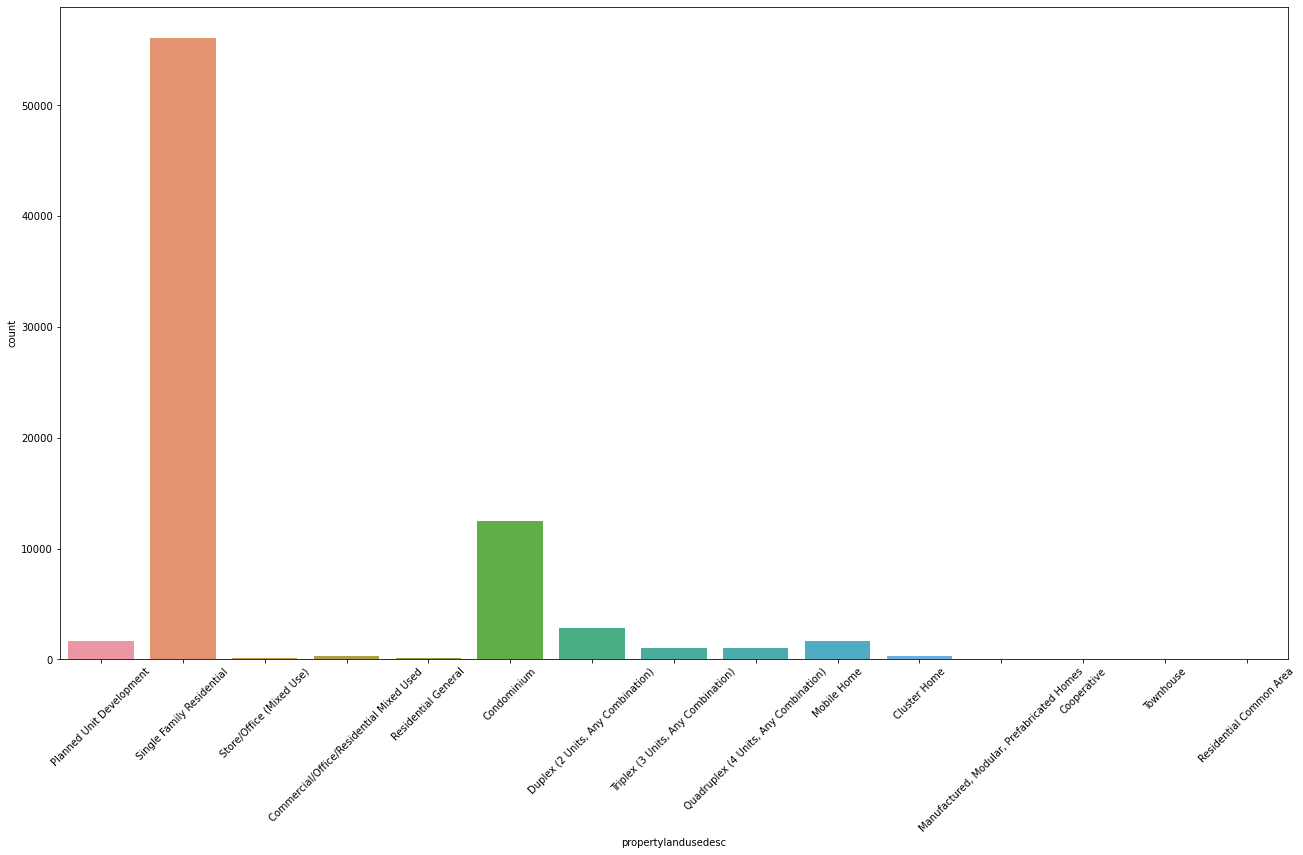

In [147]:
plt.figure(figsize=(22, 12))
land_use = sns.countplot(x = df.propertylandusedesc, data = df.sample(1000))
x_ticks = plt.xticks(rotation = 45)

### Nulls Per Column

In [9]:
def nulls_per_column(df):
    missing_values = pd.DataFrame({"num_rows_missing": df.isna().sum()})
    percent_missing = pd.DataFrame({"pct_rows_missing": (df.isna().sum()/df.shape[0])*100})
    total_missing = pd.concat([missing_values, percent_missing], axis =1)
    return total_missing

In [10]:
nulls_per_column(df)

,num_rows_missing,pct_rows_missing
typeconstructiontypeid,77448,99.786121
storytypeid,77569,99.942021
propertylandusetypeid,0,0.000000
id,0,0.000000
heatingorsystemtypeid,29139,37.543484
...,...,...
transactiondate,0,0.000000
last_trans_date,0,0.000000
propertylandusedesc,0,0.000000
storydesc,77569,99.942021


#### Takeaways

Some of our functions, such as `storytypeid` are composed of over 99% missing values. It may be necessary to drop these columns, as they do not contain enough data to be useful.

### Nulls Per Row

In [11]:
def nulls_per_column(df):
    missing_values = df.isna().sum(axis = 1)
    percent_missing = (missing_values/df.shape[1])*100
    missing_rows = df.isna().sum()
    total_missing = pd.DataFrame({'num_cols_missing': missing_values, 'pct_cols_missing': percent_missing})
    total_missing = total_missing.set_index("num_cols_missing")
    total_missing['number_rows'] = total_missing.groupby('num_cols_missing').count()
    total_missing = total_missing.drop_duplicates()
    return total_missing

In [12]:
nulls_per_column(df)

,pct_cols_missing,number_rows
num_cols_missing,,
47,68.115942,212
46,66.666667,998
37,53.623188,2861
36,52.173913,6030
44,63.768116,123
40,57.971014,297
33,47.826087,15183
45,65.217391,449
35,50.724638,5681


### Prepare

In [23]:
property_types = df[['propertylandusetypeid','propertylandusedesc']]
df_property_types = pd.DataFrame(property_types.value_counts())
df_property_types

,,0
propertylandusetypeid,propertylandusedesc,
261.0,Single Family Residential,56080
266.0,Condominium,12491
246.0,"Duplex (2 Units, Any Combination)",2852
263.0,Mobile Home,1681
269.0,Planned Unit Development,1609
247.0,"Triplex (3 Units, Any Combination)",1021
248.0,"Quadruplex (4 Units, Any Combination)",980
265.0,Cluster Home,288
31.0,Commercial/Office/Residential Mixed Used,272


In [28]:
df = df[df.propertylandusetypeid.isin([261.0, 266.0, 263.0, 269.0, 275.0, 264.0])]

In [35]:
unit_count = df['unitcnt']
df_unit_count = pd.DataFrame(unit_count.value_counts())
df_unit_count

,unitcnt
1.0,46201
2.0,23
3.0,7
4.0,1
13.0,1


In [36]:
df = df[df.unitcnt == 1.0]

In [37]:
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,id,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,basementsqft,...,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc,storydesc,typeconstructiondesc
10,NaN,NaN,269.0,10,2.0,NaN,NaN,1.0,11070347,NaN,...,Central,None,None,Central,0.005963,2017-01-02,2017-01-02,Planned Unit Development,None,None
20,NaN,NaN,261.0,20,2.0,NaN,NaN,1.0,11324547,NaN,...,Central,None,None,Central,0.042463,2017-01-02,2017-01-02,Single Family Residential,None,None
30,NaN,NaN,266.0,30,2.0,NaN,NaN,1.0,11524947,NaN,...,Central,None,None,Central,0.021853,2017-01-02,2017-01-02,Condominium,None,None
31,NaN,NaN,261.0,31,2.0,NaN,NaN,1.0,11544747,NaN,...,Central,None,None,Central,-0.019546,2017-01-02,2017-01-02,Single Family Residential,None,None
33,NaN,NaN,261.0,33,2.0,NaN,NaN,NaN,11585547,NaN,...,None,None,None,Central,-0.040807,2017-01-02,2017-01-02,Single Family Residential,None,None


### Handle Missing Values

In [38]:
def handle_missing_values(df, prop_required_column = .5, prop_required_row = .75):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [40]:
df = handle_missing_values(df, prop_required_column = .5, prop_required_row = .75)
df.head()

,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc
10,269.0,10,2.0,11070347,4.0,4.0,1.0,4.0,3095.0,3095.0,...,192544.0,2016.0,53784.0,2460.72,NaN,Central,0.005963,2017-01-02,2017-01-02,Planned Unit Development
20,261.0,20,2.0,11324547,2.0,4.0,8.0,2.0,3633.0,3633.0,...,296425.0,2016.0,74104.0,6941.39,NaN,Central,0.042463,2017-01-02,2017-01-02,Single Family Residential
30,266.0,30,2.0,11524947,2.0,2.0,7.0,2.0,1090.0,1090.0,...,357568.0,2016.0,124671.0,6165.36,NaN,Central,0.021853,2017-01-02,2017-01-02,Condominium
31,261.0,31,2.0,11544747,4.0,3.0,11.0,4.0,1620.0,1620.0,...,847770.0,2016.0,508238.0,10244.94,NaN,Central,-0.019546,2017-01-02,2017-01-02,Single Family Residential
33,261.0,33,2.0,11585547,2.0,3.0,8.0,2.0,2077.0,2077.0,...,646760.0,2016.0,436568.0,7924.68,NaN,Central,-0.040807,2017-01-02,2017-01-02,Single Family Residential


### Impute Null Values

In [48]:
def impute_null_values(df):
    '''
    We will use SimpleImputer to impute the mean value into the null values into each column.
    '''
    #We will use the mean imputer function.
    imputer = SimpleImputer(strategy='most_frequent')

    #We will create a for loop that will impute all the null values in each one of our columns.
    for col in df.columns:
        df[[col]] = imputer.fit_transform(df[[col]])
    
    return df

In [49]:
df = impute_null_values(df)

In [50]:
df.head()

,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc
10,269.0,10.0,2.0,11070347.0,4.0,4.0,1.0,4.0,3095.0,3095.0,...,192544.0,2016.0,53784.0,2460.72,6.037920e+13,Central,0.005963,2017-01-02,2017-01-02,Planned Unit Development
20,261.0,20.0,2.0,11324547.0,2.0,4.0,8.0,2.0,3633.0,3633.0,...,296425.0,2016.0,74104.0,6941.39,6.037920e+13,Central,0.042463,2017-01-02,2017-01-02,Single Family Residential
30,266.0,30.0,2.0,11524947.0,2.0,2.0,7.0,2.0,1090.0,1090.0,...,357568.0,2016.0,124671.0,6165.36,6.037920e+13,Central,0.021853,2017-01-02,2017-01-02,Condominium
31,261.0,31.0,2.0,11544747.0,4.0,3.0,11.0,4.0,1620.0,1620.0,...,847770.0,2016.0,508238.0,10244.94,6.037920e+13,Central,-0.019546,2017-01-02,2017-01-02,Single Family Residential
33,261.0,33.0,2.0,11585547.0,2.0,3.0,8.0,2.0,2077.0,2077.0,...,646760.0,2016.0,436568.0,7924.68,6.037920e+13,Central,-0.040807,2017-01-02,2017-01-02,Single Family Residential


## Mall Customers

### Acquire Data

In [55]:
#First we establish a connection to the SQL server
def get_connection(db, user=env.user, host=env.host, password=env.password):
    '''
     We establish a connection to the SQL database, using my information stored in the env file.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [11]:
def get_mall_customer_data():
    filename = "mall_customers.csv"
    sql = ''' 
    SELECT *
    FROM customers;
    '''
    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        df = pd.read_sql(sql, get_connection('mall_customers'))
        return df
    df = pd.read_sql(sql, get_connection('mall_customers'))
    return df

In [12]:
mall_customers = get_mall_customer_data()
mall_customers.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Describe Data

In [59]:
mall_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [60]:
mall_customers.describe()

,customer_id,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


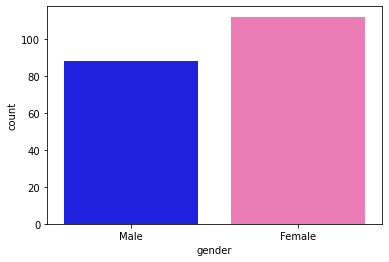

In [80]:
gender_counts = sns.countplot(data = mall_customers, x = 'gender', palette = ['blue', 'hotpink'])


In [13]:
sns.set_palette("bright")

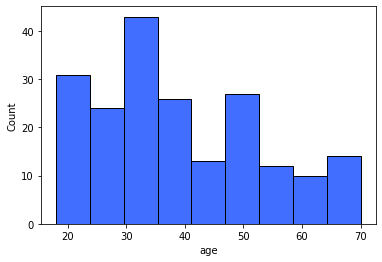

In [14]:
age_distributions = sns.histplot(x = mall_customers.age)

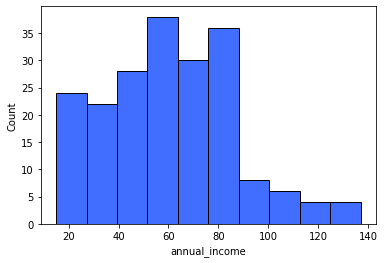

In [15]:
income_distribution = sns.histplot(data = mall_customers, x = "annual_income")

<AxesSubplot:xlabel='spending_score', ylabel='Count'>

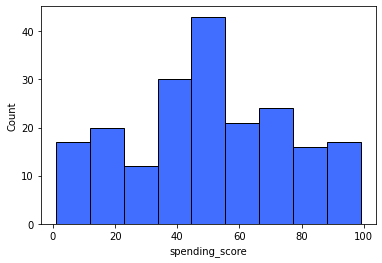

In [16]:
sns.histplot(data = mall_customers, x = "spending_score")

### Detect Outliers

In [43]:
def get_upper_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.
def add_scaled_columns(train, validate, test):
    columns_to_scale = ['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt']
    # new column names
    new_column_names = [c + '_scaled' for c in columns_to_scale]
    
    #Define scaler
    scaler_min_max = sklearn.preprocessing.MinMaxScaler()
    
    # Fit the scaler on the train
    scaler_min_max.fit(train[columns_to_scale])
    
    # transform train validate and test
    train = pd.concat([
        train,
        pd.DataFrame(scaler_min_max.transform(train[columns_to_scale]), columns=new_column_names, index=train.index),
    ], axis=1)
    
    validate = pd.concat([
        validate,
        pd.DataFrame(scaler_min_max.transform(validate[columns_to_scale]), columns=new_column_names, index=validate.index),
    ], axis=1)
    
    
    test = pd.concat([
        test,
        pd.DataFrame(scaler_min_max.transform(test[columns_to_scale]), columns=new_column_names, index=test.index),
    ], axis=1)
    
    return train, validate, test

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

In [44]:
def add_upper_outlier_columns(df, k):
    '''
    Add a column with the suffix _outliers for all the numeric columns
    in the given dataframe.
    '''
    # outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
    #                 for col in df.select_dtypes('number')}
    # return df.assign(**outlier_cols)

    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)

    return df


In [45]:
add_upper_outlier_columns(mall_customers, k=3)

mall_customers.head()

,customer_id,gender,age,annual_income,spending_score,customer_id_outliers,age_outliers,annual_income_outliers,spending_score_outliers
0,1,Male,19,15,39,0,0,0,0
1,2,Male,21,15,81,0,0,0,0
2,3,Female,20,16,6,0,0,0,0
3,4,Female,23,16,77,0,0,0,0
4,5,Female,31,17,40,0,0,0,0


### Split Data

In [51]:
def split_data(df):
    '''
    take in a DataFrame and return train, validate, and test DataFrames.
    return train, validate, test DataFrames.
    '''
    
    # splits df into train_validate and test using train_test_split() stratifying on churn to get an even mix of each churn, yes or no
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    
    # splits train_validate into train and validate using train_test_split() stratifying on churn to get an even mix of each churn
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123)
    return train, validate, test


In [52]:
train, validate, test = split_data(mall_customers)

In [53]:
train.head()

,customer_id,gender,age,annual_income,spending_score,customer_id_outliers,age_outliers,annual_income_outliers,spending_score_outliers
123,124,Male,39,69,91,0,0,0,0
76,77,Female,45,54,53,0,0,0,0
171,172,Male,28,87,75,0,0,0,0
10,11,Male,67,19,14,0,0,0,0
35,36,Female,21,33,81,0,0,0,0


In [56]:
 ## Now we will substitute the object values for dummy values that are easier to process. 
dummy_mall_customers = pd.get_dummies(mall_customers[['gender']], drop_first=True)
    
##Concatenate our dummy values to our main Dataframe. 
mall_customers = pd.concat([mall_customers, dummy_mall_customers], axis=1)

In [57]:
mall_customers

,customer_id,gender,age,annual_income,spending_score,customer_id_outliers,age_outliers,annual_income_outliers,spending_score_outliers,gender_Male
0,1,Male,19,15,39,0,0,0,0,1
1,2,Male,21,15,81,0,0,0,0,1
2,3,Female,20,16,6,0,0,0,0,0
3,4,Female,23,16,77,0,0,0,0,0
4,5,Female,31,17,40,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
195,196,Female,35,120,79,0,0,0,0,0
196,197,Female,45,126,28,0,0,0,0,0
197,198,Male,32,126,74,0,0,0,0,1
198,199,Male,32,137,18,0,0,0,0,1


### Handle Missing Values

In [58]:
def handle_missing_values(df, prop_required_column = .5, prop_required_row = .75):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [60]:
handle_missing_values(mall_customers, prop_required_column = .5, prop_required_row = .75)

,customer_id,gender,age,annual_income,spending_score,customer_id_outliers,age_outliers,annual_income_outliers,spending_score_outliers,gender_Male
0,1,Male,19,15,39,0,0,0,0,1
1,2,Male,21,15,81,0,0,0,0,1
2,3,Female,20,16,6,0,0,0,0,0
3,4,Female,23,16,77,0,0,0,0,0
4,5,Female,31,17,40,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
195,196,Female,35,120,79,0,0,0,0,0
196,197,Female,45,126,28,0,0,0,0,0
197,198,Male,32,126,74,0,0,0,0,1
198,199,Male,32,137,18,0,0,0,0,1


### Scaled Data

In [65]:
def add_scaled_columns(train, validate, test):
    columns_to_scale = ['annual_income', 'spending_score']
    # new column names
    new_column_names = [c + '_scaled' for c in columns_to_scale]
    
    #Define scaler
    scaler_min_max = sklearn.preprocessing.MinMaxScaler()
    
    # Fit the scaler on the train
    scaler_min_max.fit(train[columns_to_scale])
    
    # transform train validate and test
    train = pd.concat([
        train,
        pd.DataFrame(scaler_min_max.transform(train[columns_to_scale]), columns=new_column_names, index=train.index),
    ], axis=1)
    
    validate = pd.concat([
        validate,
        pd.DataFrame(scaler_min_max.transform(validate[columns_to_scale]), columns=new_column_names, index=validate.index),
    ], axis=1)
    
    
    test = pd.concat([
        test,
        pd.DataFrame(scaler_min_max.transform(test[columns_to_scale]), columns=new_column_names, index=test.index),
    ], axis=1)
    
    return train, validate, test


In [67]:
train, validate, test = add_scaled_columns(train, validate, test)

In [68]:
train.head()

,customer_id,gender,age,annual_income,spending_score,customer_id_outliers,age_outliers,annual_income_outliers,spending_score_outliers,annual_income_scaled,spending_score_scaled
123,124,Male,39,69,91,0,0,0,0,0.442623,0.957447
76,77,Female,45,54,53,0,0,0,0,0.319672,0.553191
171,172,Male,28,87,75,0,0,0,0,0.590164,0.787234
10,11,Male,67,19,14,0,0,0,0,0.032787,0.138298
35,36,Female,21,33,81,0,0,0,0,0.147541,0.851064
